# **THE LONDON STOCK EXCHANGE HAS NO INFLUENCE**

This notebook contains the analysis for this article (add link). The article posits that the London Stock Exchange has no influence. 

Influence is the ability to cause others to change their behaviour, beliefs, or opinion. It's not straightforward to measure, but Network Theory offers several suggestions. We averaged four definitions to calculate the importance of each stock market in the US$ 1 Trillion Club for every year from 2012 to 2022. We then lifted out London and compared the pattern of influence with its European clubmates. 

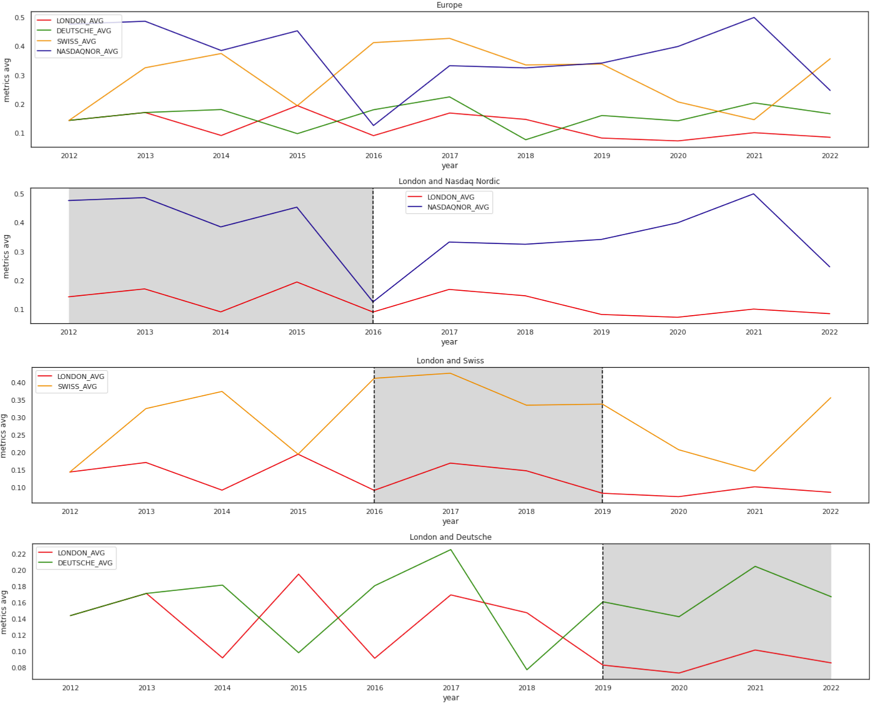

We use the networkx library for all network analyses. We install an older version so we can calculate eigenvector centralities later. The latest version of networkx does not work with multiple largest eigenvector values, but older versions have a numpy variation of the function that works for this case. Downgrading later in the process requires restarting the runtime.

In [1]:
# install an older version version of networkx 
!pip install 'networkx<2.7'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.8 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0


In [2]:
# load the relevant libraries

# for data processing
import numpy as np
import pandas as pd

# for visualisations
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

# for network analysis
import networkx as nx

# suppress
import warnings
warnings.filterwarnings('ignore')

In [3]:
# double check the version of networkx
nx.__version__

'2.6.3'

In [4]:
# mount drive if using google colab (recommended - the notebook was created in google colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **1. DATA**

Our analysis uses the [top 20](https://en.wikipedia.org/wiki/List_of_stock_exchanges) stock exchanges by market capitalisation, excluding Tehran Stock Exchange, because we could not find the data. We also exclude EuroNext because it only starts in June 2014. We collected values for the period January 1, 2012, to December 31, 2022, from [Yahoo Finance](https://https://finance.yahoo.com/), with one exception: Saudi Stock Exchange (Tadawul) numbers were unavailable and downloaded from [Investing.com](https://uk.investing.com/indices/tasi-historical-data) instead. 

### **Load and check the data**

We manually constructed a csv file with 'Adj Close' data. It's possible to scrape Yahoo Finance with the [beautiful soup](https://https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library, but you will need to know the ticker symbol for each exchange. We had to look up the tickers and, while dealing with only 18 entitities, it made sense to simply download the data while on the page. Also, scraping Yahoo Finance can be very slow.

In [5]:
# the list of tickers for scraping yahoo finance (note that Saudi Arabia Tadawul is not available)
#tickers = ['^NYA', '^IXIC', '000001.SS', '8697.T', '399001.SZ', '0388.HK', '^NSEI', 'LSEG.L', '^GSPTSE', '^SSMI', 'DB1.DE', '^OMX', 'ASX.AX', '^KS11', '^TWII', 'JSEJF', 'B3SA3.SA']

#### **Load the data**

In [6]:
# update the path and load the data into a dataframe  
value_data = pd.read_excel('YOUR_PATH_TO_THE_DATA')

#### **Check the data**

In [7]:
# check the first five rows
value_data.head()

DATE      NEWYORK       NASDAQ     SHANGHAI       JAPAN     SHENZHEN  \
0 2012-01-04  7612.149902  2648.360107  2169.389893  350.877991  8695.892578   
1 2012-01-05  7599.970215  2669.860107  2148.451904  351.274933  8600.163086   
2 2012-01-06  7557.680176  2674.219971  2163.395020  351.671875  8634.323242   
3 2012-01-09  7584.660156  2676.560059  2225.889893  351.671875  8945.979492   
4 2012-01-10  7668.899902  2702.500000  2285.743896  351.274933  9281.146484   

    HONGKONG        INDIA    SAUDI      LONDON      TORONTO        SWISS  \
0  95.690414  4749.649902  6407.87  636.189270  12226.50000  6058.080078   
1  95.005821  4749.950195  6407.87  615.768372  12237.40039  6026.569824   
2  92.799927  4754.100098  6407.87  613.411926  12188.59961  6013.830078   
3  92.952057  4742.799805  6441.62  612.233887  12196.70020  5987.540039   
4  93.712692  4849.549805  6476.60  629.120483  12270.70020  6050.779785   

    DEUTSCHE    NASDAQNOR  AUSTRALIA        KOREA       TAIWAN   JOBURG  \
0  31.050507  1006.309998  19.775120  1866.219971  7082.943848  7.04691   
1  30.767075  1002.179993  19.794184  1863.739990  7130.833008  7.04691   
2  29.775066  1002.179993  19.724281  1843.140015  7120.482910  7.04691   
3  29.864571   996.890015  19.565424  1826.489990  7093.013672  7.04691   
4  31.337662  1012.679993  19.578135  1853.219971  7178.842773  7.04691   

     BRAZIL  
0  2.171816  
1  2.148162  
2  2.180418  
3  2.214823  
4  2.259979

In [8]:
# check for missing values
value_data.isnull().sum()

DATE         0
NEWYORK      0
NASDAQ       0
SHANGHAI     0
JAPAN        0
SHENZHEN     0
HONGKONG     0
INDIA        0
SAUDI        0
LONDON       0
TORONTO      0
SWISS        0
DEUTSCHE     0
NASDAQNOR    0
AUSTRALIA    0
KOREA        0
TAIWAN       0
JOBURG       0
BRAZIL       0
dtype: int64

In [9]:
# and check the data types 
value_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   DATE       2685 non-null   datetime64[ns]
 1   NEWYORK    2685 non-null   float64       
 2   NASDAQ     2685 non-null   float64       
 3   SHANGHAI   2685 non-null   float64       
 4   JAPAN      2685 non-null   float64       
 5   SHENZHEN   2685 non-null   float64       
 6   HONGKONG   2685 non-null   float64       
 7   INDIA      2685 non-null   float64       
 8   SAUDI      2685 non-null   float64       
 9   LONDON     2685 non-null   float64       
 10  TORONTO    2685 non-null   float64       
 11  SWISS      2685 non-null   float64       
 12  DEUTSCHE   2685 non-null   float64       
 13  NASDAQNOR  2685 non-null   float64       
 14  AUSTRALIA  2685 non-null   float64       
 15  KOREA      2685 non-null   float64       
 16  TAIWAN     2685 non-null   float64       


Our data are complete with the correct Dtypes. We can move on to creating the graph in Fig 2.

### **Create the graph in Fig 2**

Fig 2 shows the evolution of market values in local currency over time from the beginning of 2012 to the end of 2022. The labels on the horizontal axis show the year at the beginning each period, and we have to set this up ourselves. The first date of trading varies by year - we need to find these dates and their indices so that we can place the labels correctly. 

In [10]:
# extract the years into a new column called 'YEAR' - we will use years as labels for the graph
value_data['YEAR'] = value_data['DATE'].dt.strftime('%Y')

In [11]:
# extract days without timestamps into a new column called 'DAY' - we will use this to find the index for each first day of the year
value_data['DAY'] = value_data['DATE'].dt.strftime('%Y-%m-%d')

In [12]:
# verify that the new columns are added correctly at the end
value_data.head()

DATE      NEWYORK       NASDAQ     SHANGHAI       JAPAN     SHENZHEN  \
0 2012-01-04  7612.149902  2648.360107  2169.389893  350.877991  8695.892578   
1 2012-01-05  7599.970215  2669.860107  2148.451904  351.274933  8600.163086   
2 2012-01-06  7557.680176  2674.219971  2163.395020  351.671875  8634.323242   
3 2012-01-09  7584.660156  2676.560059  2225.889893  351.671875  8945.979492   
4 2012-01-10  7668.899902  2702.500000  2285.743896  351.274933  9281.146484   

    HONGKONG        INDIA    SAUDI      LONDON  ...        SWISS   DEUTSCHE  \
0  95.690414  4749.649902  6407.87  636.189270  ...  6058.080078  31.050507   
1  95.005821  4749.950195  6407.87  615.768372  ...  6026.569824  30.767075   
2  92.799927  4754.100098  6407.87  613.411926  ...  6013.830078  29.775066   
3  92.952057  4742.799805  6441.62  612.233887  ...  5987.540039  29.864571   
4  93.712692  4849.549805  6476.60  629.120483  ...  6050.779785  31.337662   

     NASDAQNOR  AUSTRALIA        KOREA       TAIWAN   JOBURG    BRAZIL  YEAR  \
0  1006.309998  19.775120  1866.219971  7082.943848  7.04691  2.171816  2012   
1  1002.179993  19.794184  1863.739990  7130.833008  7.04691  2.148162  2012   
2  1002.179993  19.724281  1843.140015  7120.482910  7.04691  2.180418  2012   
3   996.890015  19.565424  1826.489990  7093.013672  7.04691  2.214823  2012   
4  1012.679993  19.578135  1853.219971  7178.842773  7.04691  2.259979  2012   

          DAY  
0  2012-01-04  
1  2012-01-05  
2  2012-01-06  
3  2012-01-09  
4  2012-01-10  

[5 rows x 21 columns]

In [13]:
# make a list of unique years in the dataset
years = value_data['YEAR'].unique().tolist()
years

['2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022']

In [14]:
# and find the first day of trading for each year

# create an empty list
first_day = []

# function to find the smallest date for each year
for year in years:
  first_day.append(value_data[value_data['YEAR']==year]['DAY'].min())

# display the list
first_day

['2012-01-04',
 '2013-01-04',
 '2014-01-02',
 '2015-01-05',
 '2016-01-04',
 '2017-01-03',
 '2018-01-02',
 '2019-01-02',
 '2020-01-02',
 '2021-01-04',
 '2022-01-04']

In [15]:
# use the first day of trading to locate the relevant index and store it in a list
# the index comes as an array value, and we convert the list of arrays into a regular list in at the end
index_ticks = []

index_ticks.append(value_data[value_data['DAY']=='2012-01-04'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2013-01-04'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2014-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2015-01-05'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2016-01-04'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2017-01-03'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2018-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2019-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2020-01-02'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2021-01-04'].index.values)
index_ticks.append(value_data[value_data['DAY']=='2022-01-04'].index.values)

# turn list of arrays into list of lists
index_ticks = [i.tolist() for i in index_ticks]

# combine lists of lists into a single list
ticks = sum(index_ticks, [])

# display the list
ticks

[0, 242, 485, 730, 975, 1218, 1463, 1710, 1950, 2196, 2440]

[Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Stock exchange value'),
 Text(0.5, 1.0, 'The 18 Stock Exchanges in our analysis')]

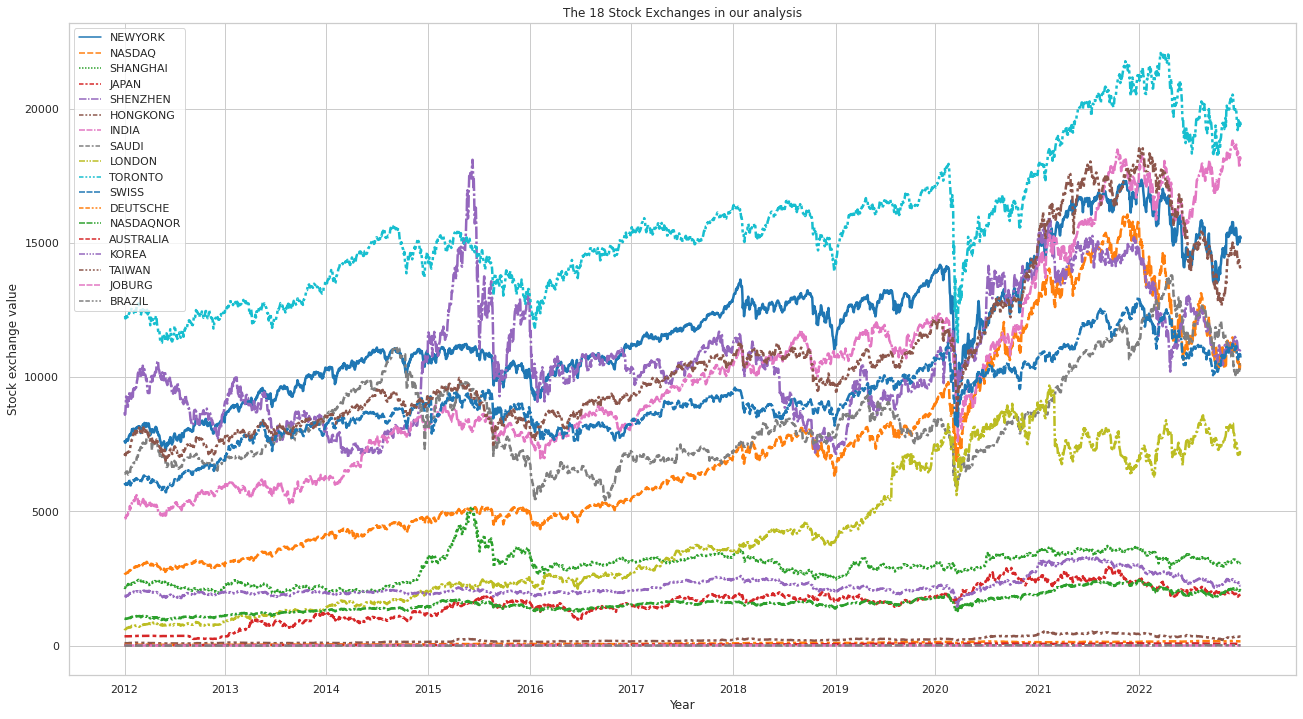

In [16]:
# Now we have everything we need to create the graph

# set the theme for the plot
sns.set_theme(style="whitegrid")

# create the plot
figure = plt.figure(figsize=(22,12))
g = sns.lineplot(data=value_data, palette="tab10", linewidth=2.5)

# set the ticks using the list of index values
g.set_xticks(ticks)

# set the label names for each tick using the list of years
g.set_xticklabels(years)

# add title and axis names
g.set(xlabel = 'Year',
      ylabel = 'Stock exchange value',
      title = 'The 18 Stock Exchanges in our analysis')

## **2. FINDING THE NETWORK FOR EACH YEAR**

We find the networks for our 18 stock exchanges in three steps. First, we calculate daily returns. Second, we find the correlations between the returns for each stock exchange and every other stock exchange. And finally, we convert the correlation coefficients into distances and draw a network that maintains only the significant links. 

In [17]:
# we split the data into dataframe from each year, but let's tidy up so that we don't have to repeat the same processes on separate dataframes later
# drop the columns 'YEAR' and 'DAY' because we don't want to calculate correlations for these
value_data_tidy = value_data.drop(columns = ['YEAR', 'DAY'])

In [18]:
# and set DATE as the index so that we can use the shift() function later
value_data_tidy.set_index('DATE', inplace=True)

### **Split the data into years**

In [19]:
# create a function to get data by year from the index by using loc[] 

def get_data_by_year(data, year):
  data_by_year = data.loc['{}-01-01'.format(year):'{}-12-31'.format(year)]

  return data_by_year

In [20]:
# and call the function to get data by year in separate dataframes
value_data_2012 = get_data_by_year(value_data_tidy, 2012)
value_data_2013 = get_data_by_year(value_data_tidy, 2013)
value_data_2014 = get_data_by_year(value_data_tidy, 2014)
value_data_2015 = get_data_by_year(value_data_tidy, 2015)
value_data_2016 = get_data_by_year(value_data_tidy, 2016)
value_data_2017 = get_data_by_year(value_data_tidy, 2017)
value_data_2018 = get_data_by_year(value_data_tidy, 2018)
value_data_2019 = get_data_by_year(value_data_tidy, 2019)
value_data_2020 = get_data_by_year(value_data_tidy, 2020)
value_data_2021 = get_data_by_year(value_data_tidy, 2021)
value_data_2022 = get_data_by_year(value_data_tidy, 2022)

In [21]:
# check that the type is indeed dataframe by looking at 2012
type(value_data_2012)

pandas.core.frame.DataFrame

In [22]:
# and also check that the data look as expected
value_data_2012

NEWYORK       NASDAQ     SHANGHAI       JAPAN     SHENZHEN  \
DATE                                                                         
2012-01-04  7612.149902  2648.360107  2169.389893  350.877991  8695.892578   
2012-01-05  7599.970215  2669.860107  2148.451904  351.274933  8600.163086   
2012-01-06  7557.680176  2674.219971  2163.395020  351.671875  8634.323242   
2012-01-09  7584.660156  2676.560059  2225.889893  351.671875  8945.979492   
2012-01-10  7668.899902  2702.500000  2285.743896  351.274933  9281.146484   
...                 ...          ...          ...         ...          ...   
2012-12-19  8463.820313  3044.360107  2162.239014  347.843964  8639.462891   
2012-12-20  8516.429688  3050.389893  2168.353027  352.298340  8693.132813   
2012-12-21  8443.150391  3021.010010  2153.310059  346.629120  8658.252930   
2012-12-27  8399.830078  2985.909912  2205.896973  330.836456  8939.749023   
2012-12-28  8316.160156  2960.310059  2233.251953  348.248901  9026.889648   

              HONGKONG        INDIA    SAUDI      LONDON      TORONTO  \
DATE                                                                    
2012-01-04   95.690414  4749.649902  6407.87  636.189270  12226.50000   
2012-01-05   95.005821  4749.950195  6407.87  615.768372  12237.40039   
2012-01-06   92.799927  4754.100098  6407.87  613.411926  12188.59961   
2012-01-09   92.952057  4742.799805  6441.62  612.233887  12196.70020   
2012-01-10   93.712692  4849.549805  6476.60  629.120483  12270.70020   
...                ...          ...      ...         ...          ...   
2012-12-19  103.356140  5929.600098  6888.58  895.393555  12403.59961   
2012-12-20  102.884209  5916.399902  6888.58  890.536194  12388.70020   
2012-12-21  102.254944  5847.700195  6888.58  884.869141  12385.70020   
2012-12-27  103.670792  5870.100098  6888.58  883.250061  12373.79981   
2012-12-28  103.749435  5908.350098  6888.58  887.297852  12316.09961   

                  SWISS   DEUTSCHE    NASDAQNOR  AUSTRALIA        KOREA  \
DATE                                                                      
2012-01-04  6058.080078  31.050507  1006.309998  19.775120  1866.219971   
2012-01-05  6026.569824  30.767075  1002.179993  19.794184  1863.739990   
2012-01-06  6013.830078  29.775066  1002.179993  19.724281  1843.140015   
2012-01-09  5987.540039  29.864571   996.890015  19.565424  1826.489990   
2012-01-10  6050.779785  31.337662  1012.679993  19.578135  1853.219971   
...                 ...        ...          ...        ...          ...   
2012-12-19  6946.069824  35.077572  1108.939941  20.791527  1993.089966   
2012-12-20  6912.790039  35.344425  1108.069946  20.952967  1999.500000   
2012-12-21  6889.540039  35.466427  1107.930054  20.993322  1980.420044   
2012-12-27  6862.549805  35.474056  1110.910034  21.067312  1987.349976   
2012-12-28  6822.439941  35.233871  1104.729980  21.121124  1997.050049   

                 TAIWAN   JOBURG    BRAZIL  
DATE                                        
2012-01-04  7082.943848  7.04691  2.171816  
2012-01-05  7130.833008  7.04691  2.148162  
2012-01-06  7120.482910  7.04691  2.180418  
2012-01-09  7093.013672  7.04691  2.214823  
2012-01-10  7178.842773  7.04691  2.259979  
...                 ...      ...       ...  
2012-12-19  7677.441406  6.15771  3.189675  
2012-12-20  7595.431152  6.15771  3.116065  
2012-12-21  7519.901855  6.15771  3.073687  
2012-12-27  7648.381348  6.15771  3.073687  
2012-12-28  7699.471191  6.15771  3.122759  

[242 rows x 18 columns]

### **Calculate daily returns**

We use daily log returns. There are two good reasons for this choice. One, simple returns tend to follow a log-normal distribution. So if we use log returns, we can work with a normal distribution, and the normal distribution makes life easy. And two, we are interested in multiplicative returns: we want to know whether a stock doubled in value rather than that it increased by, say, 5 dollars.

We calculate daily log returns using the shift() function to move the Adjusted Close data to the next day. Then we take the difference between the original data (having the value for today) and the shifted data (having the value for yesterday) to get a daily change.

In [23]:
# let's look at how the shift function works with 2012 - in our original data NEWYORK has a value of 7612.149902 on 2012-01-04 (see table above)
# with shift(1) we expect that value to shift by one day to the next day, 2012-01-05
# so we move the Adjusted Close values from day n to day n+1
value_data_2012.shift(1)

NEWYORK       NASDAQ     SHANGHAI       JAPAN     SHENZHEN  \
DATE                                                                         
2012-01-04          NaN          NaN          NaN         NaN          NaN   
2012-01-05  7612.149902  2648.360107  2169.389893  350.877991  8695.892578   
2012-01-06  7599.970215  2669.860107  2148.451904  351.274933  8600.163086   
2012-01-09  7557.680176  2674.219971  2163.395020  351.671875  8634.323242   
2012-01-10  7584.660156  2676.560059  2225.889893  351.671875  8945.979492   
...                 ...          ...          ...         ...          ...   
2012-12-19  8499.349609  3054.530029  2162.464111  326.382080  8592.533203   
2012-12-20  8463.820313  3044.360107  2162.239014  347.843964  8639.462891   
2012-12-21  8516.429688  3050.389893  2168.353027  352.298340  8693.132813   
2012-12-27  8443.150391  3021.010010  2153.310059  346.629120  8658.252930   
2012-12-28  8399.830078  2985.909912  2205.896973  330.836456  8939.749023   

              HONGKONG        INDIA    SAUDI      LONDON      TORONTO  \
DATE                                                                    
2012-01-04         NaN          NaN      NaN         NaN          NaN   
2012-01-05   95.690414  4749.649902  6407.87  636.189270  12226.50000   
2012-01-06   95.005821  4749.950195  6407.87  615.768372  12237.40039   
2012-01-09   92.799927  4754.100098  6407.87  613.411926  12188.59961   
2012-01-10   92.952057  4742.799805  6441.62  612.233887  12196.70020   
...                ...          ...      ...         ...          ...   
2012-12-19  102.726891  5896.799805  6858.24  870.296692  12334.29981   
2012-12-20  103.356140  5929.600098  6888.58  895.393555  12403.59961   
2012-12-21  102.884209  5916.399902  6888.58  890.536194  12388.70020   
2012-12-27  102.254944  5847.700195  6888.58  884.869141  12385.70020   
2012-12-28  103.670792  5870.100098  6888.58  883.250061  12373.79981   

                  SWISS   DEUTSCHE    NASDAQNOR  AUSTRALIA        KOREA  \
DATE                                                                      
2012-01-04          NaN        NaN          NaN        NaN          NaN   
2012-01-05  6058.080078  31.050507  1006.309998  19.775120  1866.219971   
2012-01-06  6026.569824  30.767075  1002.179993  19.794184  1863.739990   
2012-01-09  6013.830078  29.775066  1002.179993  19.724281  1843.140015   
2012-01-10  5987.540039  29.864571   996.890015  19.565424  1826.489990   
...                 ...        ...          ...        ...          ...   
2012-12-19  6912.089844  34.955570  1107.479980  20.596460  1993.089966   
2012-12-20  6946.069824  35.077572  1108.939941  20.791527  1993.089966   
2012-12-21  6912.790039  35.344425  1108.069946  20.952967  1999.500000   
2012-12-27  6889.540039  35.466427  1107.930054  20.993322  1980.420044   
2012-12-28  6862.549805  35.474056  1110.910034  21.067312  1987.349976   

                 TAIWAN   JOBURG    BRAZIL  
DATE                                        
2012-01-04          NaN      NaN       NaN  
2012-01-05  7082.943848  7.04691  2.171816  
2012-01-06  7130.833008  7.04691  2.148162  
2012-01-09  7120.482910  7.04691  2.180418  
2012-01-10  7093.013672  7.04691  2.214823  
...                 ...      ...       ...  
2012-12-19  7643.711426  6.15771  3.091531  
2012-12-20  7677.441406  6.15771  3.189675  
2012-12-21  7595.431152  6.15771  3.116065  
2012-12-27  7519.901855  6.15771  3.073687  
2012-12-28  7648.381348  6.15771  3.073687  

[242 rows x 18 columns]

In [24]:
# and then calculate the daily log returns as today's value minus yesterday's value for each year
log_returns_2012 = np.log(value_data_2012) - np.log(value_data_2012.shift(1))
log_returns_2013 = np.log(value_data_2013) - np.log(value_data_2013.shift(1))
log_returns_2014 = np.log(value_data_2014) - np.log(value_data_2014.shift(1))
log_returns_2015 = np.log(value_data_2015) - np.log(value_data_2015.shift(1))
log_returns_2016 = np.log(value_data_2016) - np.log(value_data_2016.shift(1))
log_returns_2017 = np.log(value_data_2017) - np.log(value_data_2017.shift(1))
log_returns_2018 = np.log(value_data_2018) - np.log(value_data_2018.shift(1))
log_returns_2019 = np.log(value_data_2019) - np.log(value_data_2019.shift(1))
log_returns_2020 = np.log(value_data_2020) - np.log(value_data_2020.shift(1))
log_returns_2021 = np.log(value_data_2021) - np.log(value_data_2021.shift(1))
log_returns_2022 = np.log(value_data_2022) - np.log(value_data_2022.shift(1))

### **Find the correlations**

In [25]:
# calculate the corrections for each year
log_returns_2012_corr = log_returns_2012.corr()
log_returns_2013_corr = log_returns_2013.corr()
log_returns_2014_corr = log_returns_2014.corr()
log_returns_2015_corr = log_returns_2015.corr()
log_returns_2016_corr = log_returns_2016.corr()
log_returns_2017_corr = log_returns_2017.corr()
log_returns_2018_corr = log_returns_2018.corr()
log_returns_2019_corr = log_returns_2019.corr()
log_returns_2020_corr = log_returns_2020.corr()
log_returns_2021_corr = log_returns_2021.corr()
log_returns_2022_corr = log_returns_2022.corr()

In [26]:
# let's check 2013 - we've calculated correlations, so we expect to see values between -1 and 1 with 1's on the diagonal
log_returns_2013_corr

NEWYORK    NASDAQ  SHANGHAI     JAPAN  SHENZHEN  HONGKONG  \
NEWYORK    1.000000  0.885907  0.084630  0.156314  0.072413  0.167018   
NASDAQ     0.885907  1.000000  0.080292  0.088498  0.088564  0.108422   
SHANGHAI   0.084630  0.080292  1.000000  0.094073  0.934713  0.552102   
JAPAN      0.156314  0.088498  0.094073  1.000000  0.079839  0.125318   
SHENZHEN   0.072413  0.088564  0.934713  0.079839  1.000000  0.511211   
HONGKONG   0.167018  0.108422  0.552102  0.125318  0.511211  1.000000   
INDIA      0.311589  0.254338  0.171260  0.122895  0.120994  0.303446   
SAUDI      0.074578  0.080472  0.124417  0.055725  0.127671  0.096132   
LONDON     0.390220  0.374927  0.058549  0.115230  0.054062  0.116497   
TORONTO    0.739001  0.640028  0.182152  0.070261  0.155945  0.250180   
SWISS      0.450816  0.416050  0.129660  0.166801  0.116086  0.274171   
DEUTSCHE   0.252095  0.231796  0.102218  0.062782  0.077101  0.159082   
NASDAQNOR  0.600469  0.547887  0.152406  0.148161  0.153604  0.281971   
AUSTRALIA  0.194939  0.136178  0.185821  0.106336  0.179834  0.149205   
KOREA      0.175487  0.148578  0.373726  0.152393  0.342081  0.366880   
TAIWAN     0.076703  0.077333  0.424341  0.198606  0.400682  0.387631   
JOBURG     0.020880  0.076345  0.032475 -0.086511  0.060937  0.010415   
BRAZIL     0.469076  0.427725  0.073531 -0.051462  0.057436  0.101403   

              INDIA     SAUDI    LONDON   TORONTO     SWISS  DEUTSCHE  \
NEWYORK    0.311589  0.074578  0.390220  0.739001  0.450816  0.252095   
NASDAQ     0.254338  0.080472  0.374927  0.640028  0.416050  0.231796   
SHANGHAI   0.171260  0.124417  0.058549  0.182152  0.129660  0.102218   
JAPAN      0.122895  0.055725  0.115230  0.070261  0.166801  0.062782   
SHENZHEN   0.120994  0.127671  0.054062  0.155945  0.116086  0.077101   
HONGKONG   0.303446  0.096132  0.116497  0.250180  0.274171  0.159082   
INDIA      1.000000  0.087843  0.284784  0.324010  0.360368  0.291601   
SAUDI      0.087843  1.000000  0.180309  0.098567  0.117511  0.220043   
LONDON     0.284784  0.180309  1.000000  0.341361  0.560655  0.506679   
TORONTO    0.324010  0.098567  0.341361  1.000000  0.418875  0.310015   
SWISS      0.360368  0.117511  0.560655  0.418875  1.000000  0.523316   
DEUTSCHE   0.291601  0.220043  0.506679  0.310015  0.523316  1.000000   
NASDAQNOR  0.380492  0.157497  0.516537  0.517007  0.749430  0.498150   
AUSTRALIA  0.089981  0.099255  0.340643  0.211901  0.337955  0.216924   
KOREA      0.341216  0.109855  0.191611  0.268024  0.247670  0.228283   
TAIWAN     0.336987  0.099826  0.074054  0.144231  0.191654  0.131576   
JOBURG    -0.008390  0.014600  0.050107  0.000667  0.002334 -0.002852   
BRAZIL     0.195371  0.069397  0.211656  0.432307  0.212102  0.219529   

           NASDAQNOR  AUSTRALIA     KOREA    TAIWAN    JOBURG    BRAZIL  
NEWYORK     0.600469   0.194939  0.175487  0.076703  0.020880  0.469076  
NASDAQ      0.547887   0.136178  0.148578  0.077333  0.076345  0.427725  
SHANGHAI    0.152406   0.185821  0.373726  0.424341  0.032475  0.073531  
JAPAN       0.148161   0.106336  0.152393  0.198606 -0.086511 -0.051462  
SHENZHEN    0.153604   0.179834  0.342081  0.400682  0.060937  0.057436  
HONGKONG    0.281971   0.149205  0.366880  0.387631  0.010415  0.101403  
INDIA       0.380492   0.089981  0.341216  0.336987 -0.008390  0.195371  
SAUDI       0.157497   0.099255  0.109855  0.099826  0.014600  0.069397  
LONDON      0.516537   0.340643  0.191611  0.074054  0.050107  0.211656  
TORONTO     0.517007   0.211901  0.268024  0.144231  0.000667  0.432307  
SWISS       0.749430   0.337955  0.247670  0.191654  0.002334  0.212102  
DEUTSCHE    0.498150   0.216924  0.228283  0.131576 -0.002852  0.219529  
NASDAQNOR   1.000000   0.282544  0.388760  0.211352 -0.046963  0.311588  
AUSTRALIA   0.282544   1.000000  0.294566  0.263876  0.013063  0.057528  
KOREA       0.388760   0.294566  1.000000  0.605685  0.030741  0.195354  
TAIWAN      0.211352   0.263876  0.605685  1.000000 

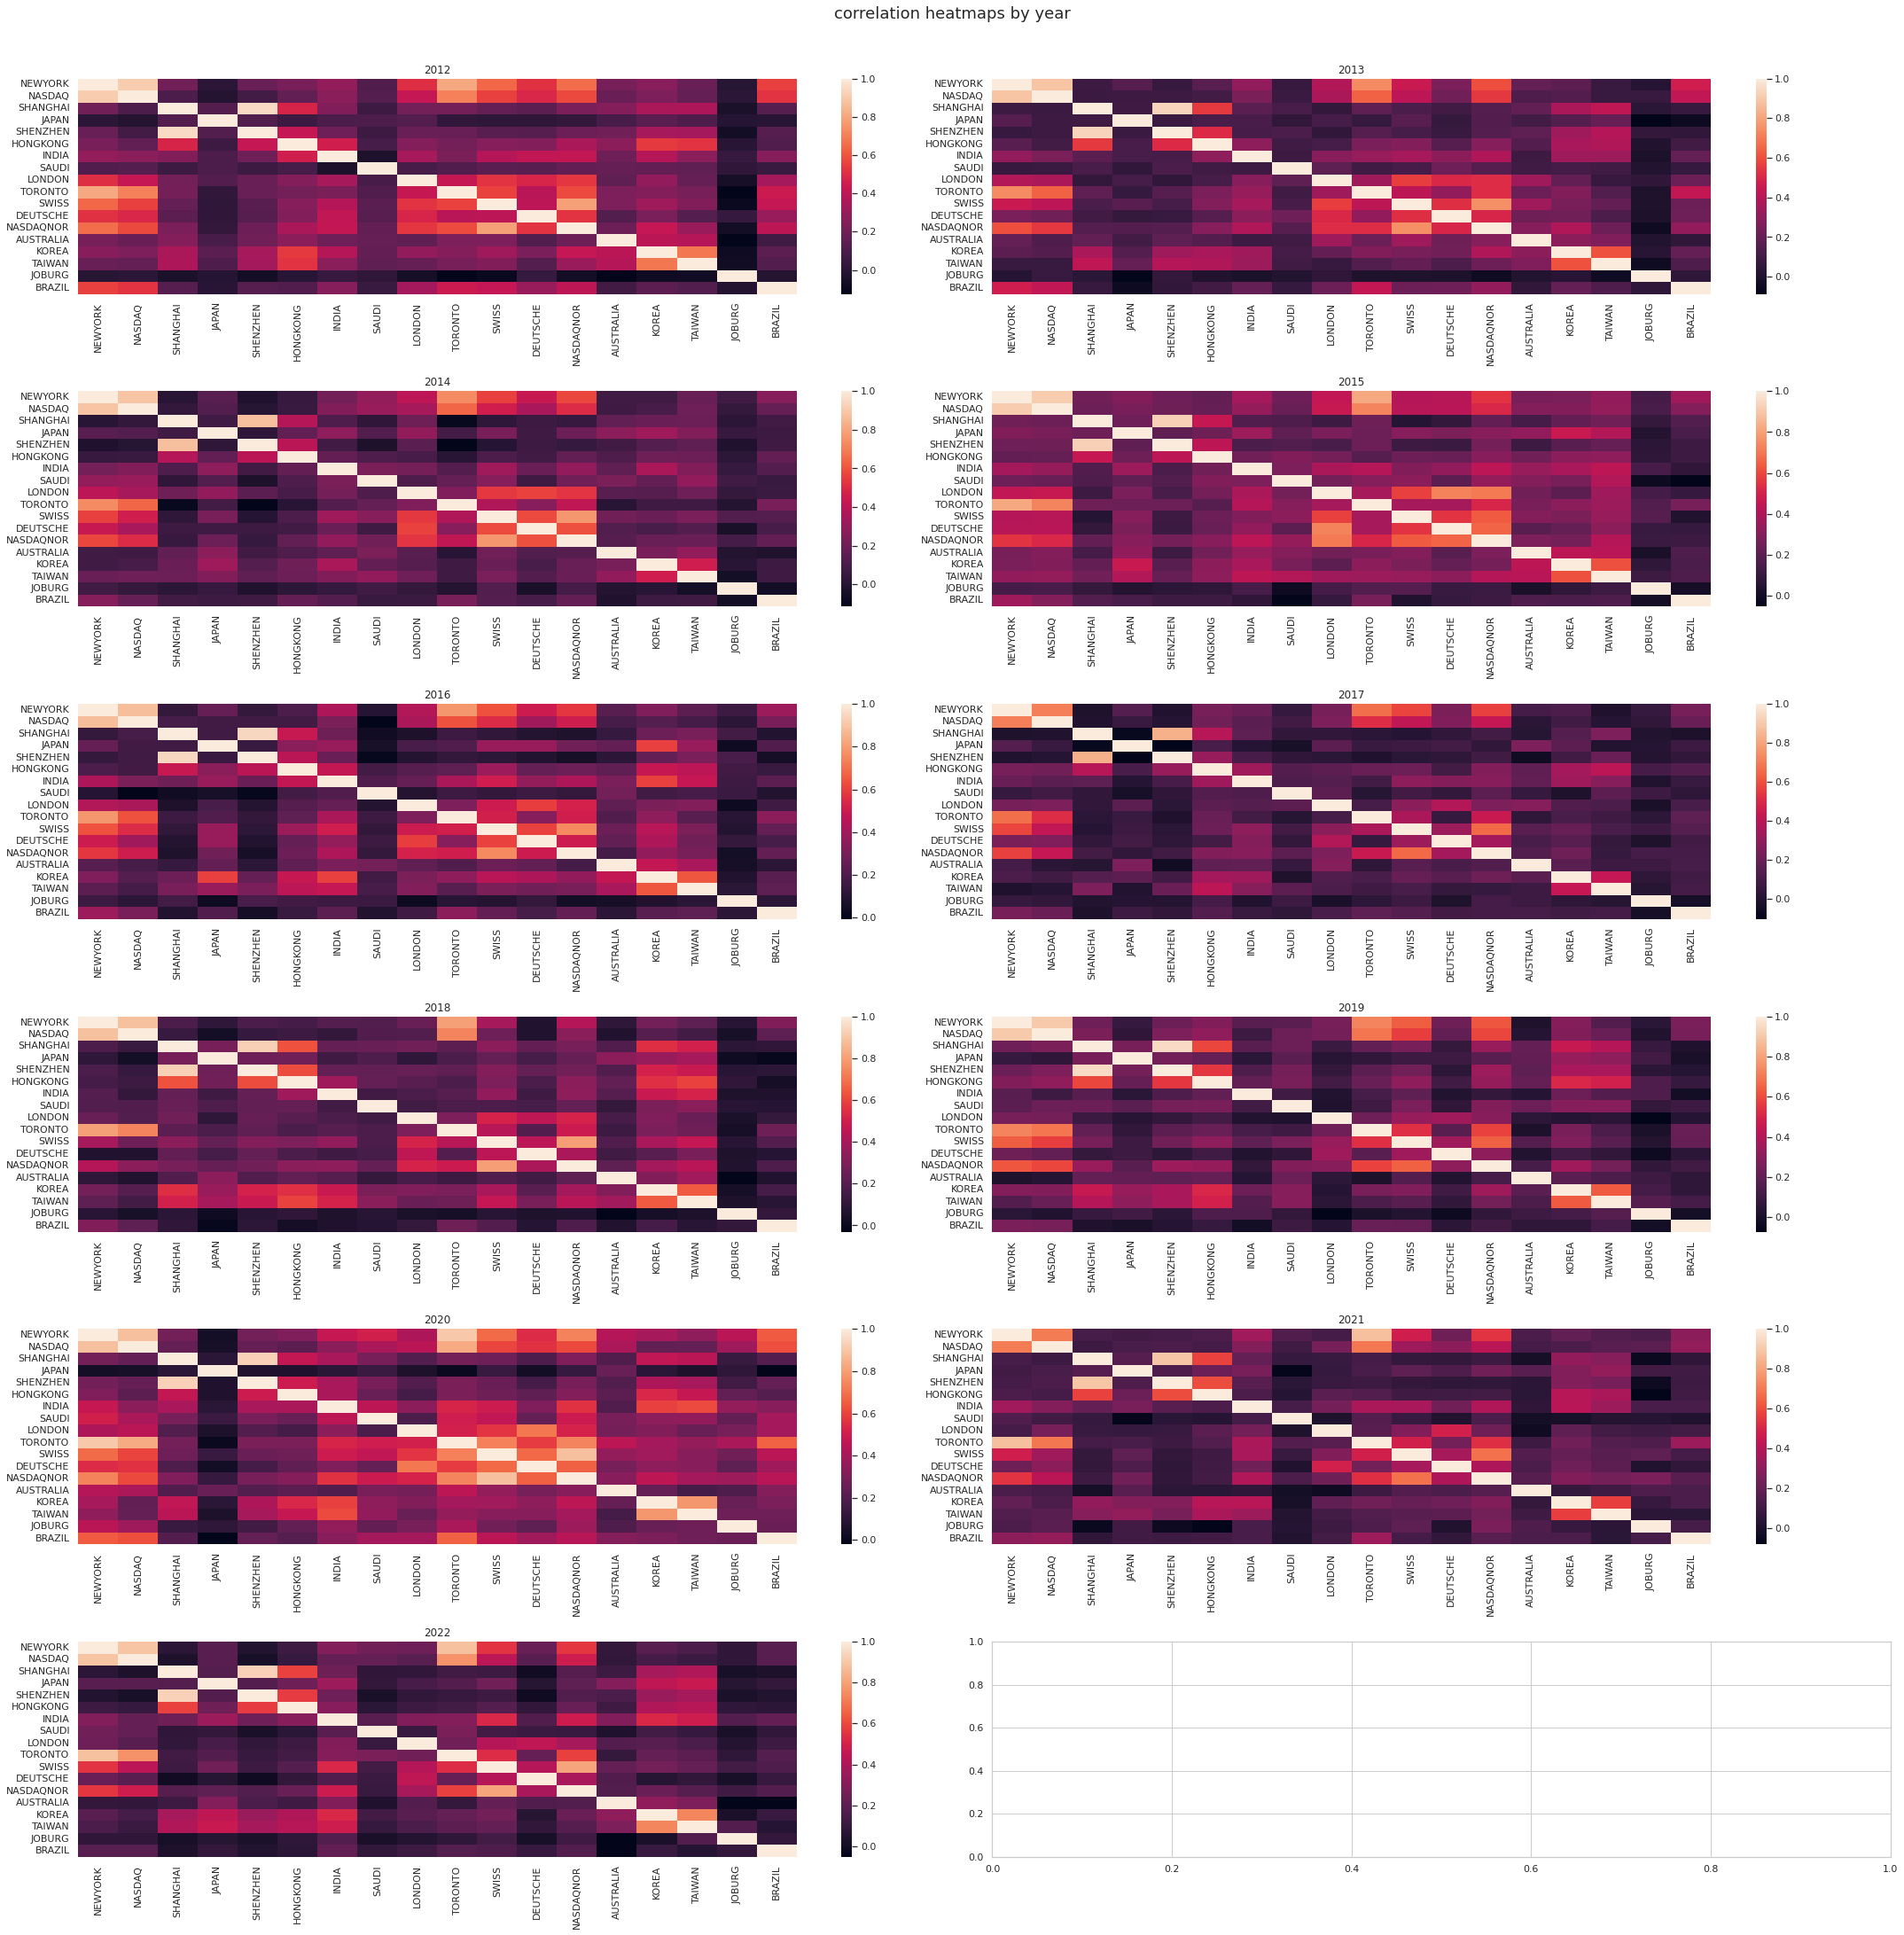

In [27]:
# and create the heatmaps to have some idea of what to expect
# a heatmap with a lighter overall hue suggests some global event that affected all markets (e.g. 2020 when the pandemic first hit vs 2021)
fig, axes = plt.subplots(6, 2, figsize=(30, 30))
sns.heatmap(log_returns_2012_corr, ax=axes[0, 0]).set_title('2012');
sns.heatmap(log_returns_2013_corr, ax=axes[0, 1]).set_title('2013');

sns.heatmap(log_returns_2014_corr, ax=axes[1, 0]).set_title('2014');
sns.heatmap(log_returns_2015_corr, ax=axes[1, 1]).set_title('2015');

sns.heatmap(log_returns_2016_corr, ax=axes[2, 0]).set_title('2016');
sns.heatmap(log_returns_2017_corr, ax=axes[2, 1]).set_title('2017');

sns.heatmap(log_returns_2018_corr, ax=axes[3, 0]).set_title('2018');
sns.heatmap(log_returns_2019_corr, ax=axes[3, 1]).set_title('2019');

sns.heatmap(log_returns_2020_corr, ax=axes[4, 0]).set_title('2020');
sns.heatmap(log_returns_2021_corr, ax=axes[4, 1]).set_title('2021');

sns.heatmap(log_returns_2022_corr, ax=axes[5, 0]).set_title('2022');

fig.suptitle('correlation heatmaps by year', y=1.01, fontsize=18)
fig.tight_layout()

plt.show()


But we use the correlation matrices to create fully connected networks. After creating the fully connected networks, we can use filter out Minimum Spanning Trees to have only the important connections left.

In [28]:
# let's look at 2014 for an example - first define data for the fully connected graph
fully_connected_graph_2014 = nx.Graph(log_returns_2014_corr)

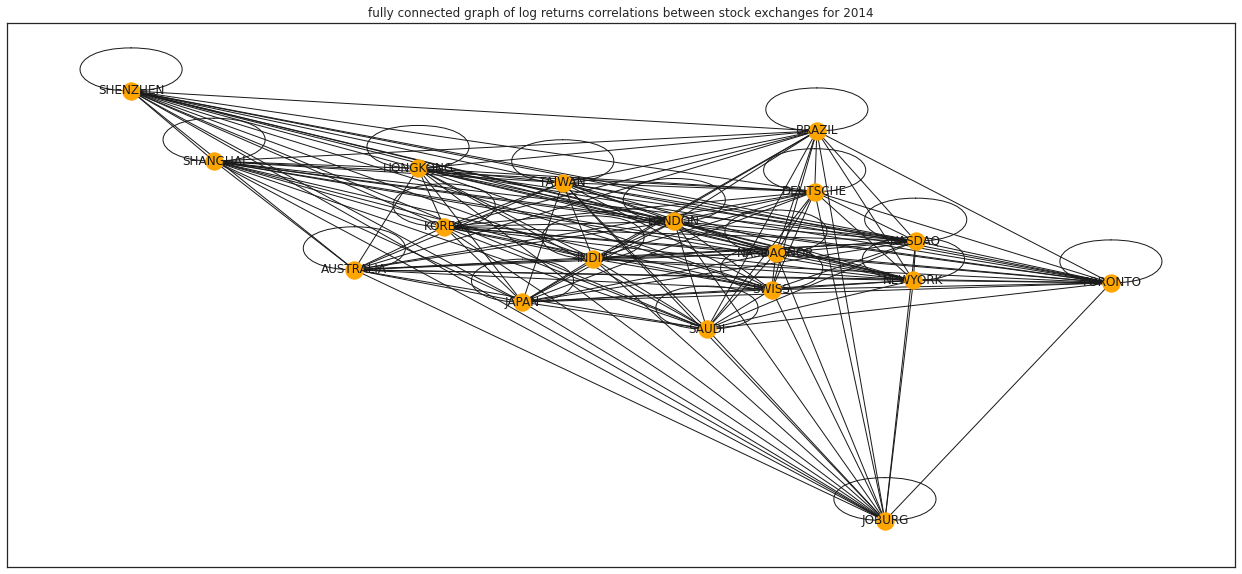

In [29]:
# and then draw the graph
sns.set_theme(style="white")

figure = plt.figure(figsize=(22, 10))
plt.title('fully connected graph of log returns correlations between stock exchanges for 2014')

nx.draw_networkx(fully_connected_graph_2014, with_labels=True, node_color='orange')

Each orange circle (*node*) represents one of the 18 stock exchanges, and the nodes are connected by lines (*edges*). A thicker edge indicates a stronger correlation between two nodes, and a loop is the correlation of a node with itself. Johannesburg (JOBURG) is far removed because it has low correlations with all other nodes in 2014 - check the heatmap to see the same. 

### **Draw the network**

The network would be more informative if we eliminated redundancies and noise. A Minimum Spanning Tree (MST) can help identify the relationships that matter. First, we need distances of some kind. We convert the correlation coefficients into distances by taking the square root of 2 * (1 – correlation coefficient). That gives us short distances between nodes with high correlations and longer distances otherwise. Then we can create a fully connected graphs, and finally filter out the MSTs and visualise the networks of meaningful relationships in Fig 3.

In [30]:
# calculate distances for each year
distance_2012 = np.sqrt(2 * (1 - log_returns_2012_corr))
distance_2013 = np.sqrt(2 * (1 - log_returns_2013_corr))
distance_2014 = np.sqrt(2 * (1 - log_returns_2014_corr))
distance_2015 = np.sqrt(2 * (1 - log_returns_2015_corr))
distance_2016 = np.sqrt(2 * (1 - log_returns_2016_corr))
distance_2017 = np.sqrt(2 * (1 - log_returns_2017_corr))
distance_2018 = np.sqrt(2 * (1 - log_returns_2018_corr))
distance_2019 = np.sqrt(2 * (1 - log_returns_2019_corr))
distance_2020 = np.sqrt(2 * (1 - log_returns_2020_corr))
distance_2021 = np.sqrt(2 * (1 - log_returns_2021_corr))
distance_2022 = np.sqrt(2 * (1 - log_returns_2022_corr))

In [31]:
# create fully connected graphs for each year using the distance
fully_connected_2012 = nx.Graph(distance_2012)
fully_connected_2013 = nx.Graph(distance_2013)
fully_connected_2014 = nx.Graph(distance_2014)
fully_connected_2015 = nx.Graph(distance_2015)
fully_connected_2016 = nx.Graph(distance_2016)
fully_connected_2017 = nx.Graph(distance_2017)
fully_connected_2018 = nx.Graph(distance_2018)
fully_connected_2019 = nx.Graph(distance_2019)
fully_connected_2020 = nx.Graph(distance_2020)
fully_connected_2021 = nx.Graph(distance_2021)
fully_connected_2022 = nx.Graph(distance_2022)

In [32]:
# and filter out the mst for each year
mst_2012 = nx.minimum_spanning_tree(fully_connected_2012)
mst_2013 = nx.minimum_spanning_tree(fully_connected_2013)
mst_2014 = nx.minimum_spanning_tree(fully_connected_2014)
mst_2015 = nx.minimum_spanning_tree(fully_connected_2015)
mst_2016 = nx.minimum_spanning_tree(fully_connected_2016)
mst_2017 = nx.minimum_spanning_tree(fully_connected_2017)
mst_2018 = nx.minimum_spanning_tree(fully_connected_2018)
mst_2019 = nx.minimum_spanning_tree(fully_connected_2019)
mst_2020 = nx.minimum_spanning_tree(fully_connected_2020)
mst_2021 = nx.minimum_spanning_tree(fully_connected_2021)
mst_2022 = nx.minimum_spanning_tree(fully_connected_2022)

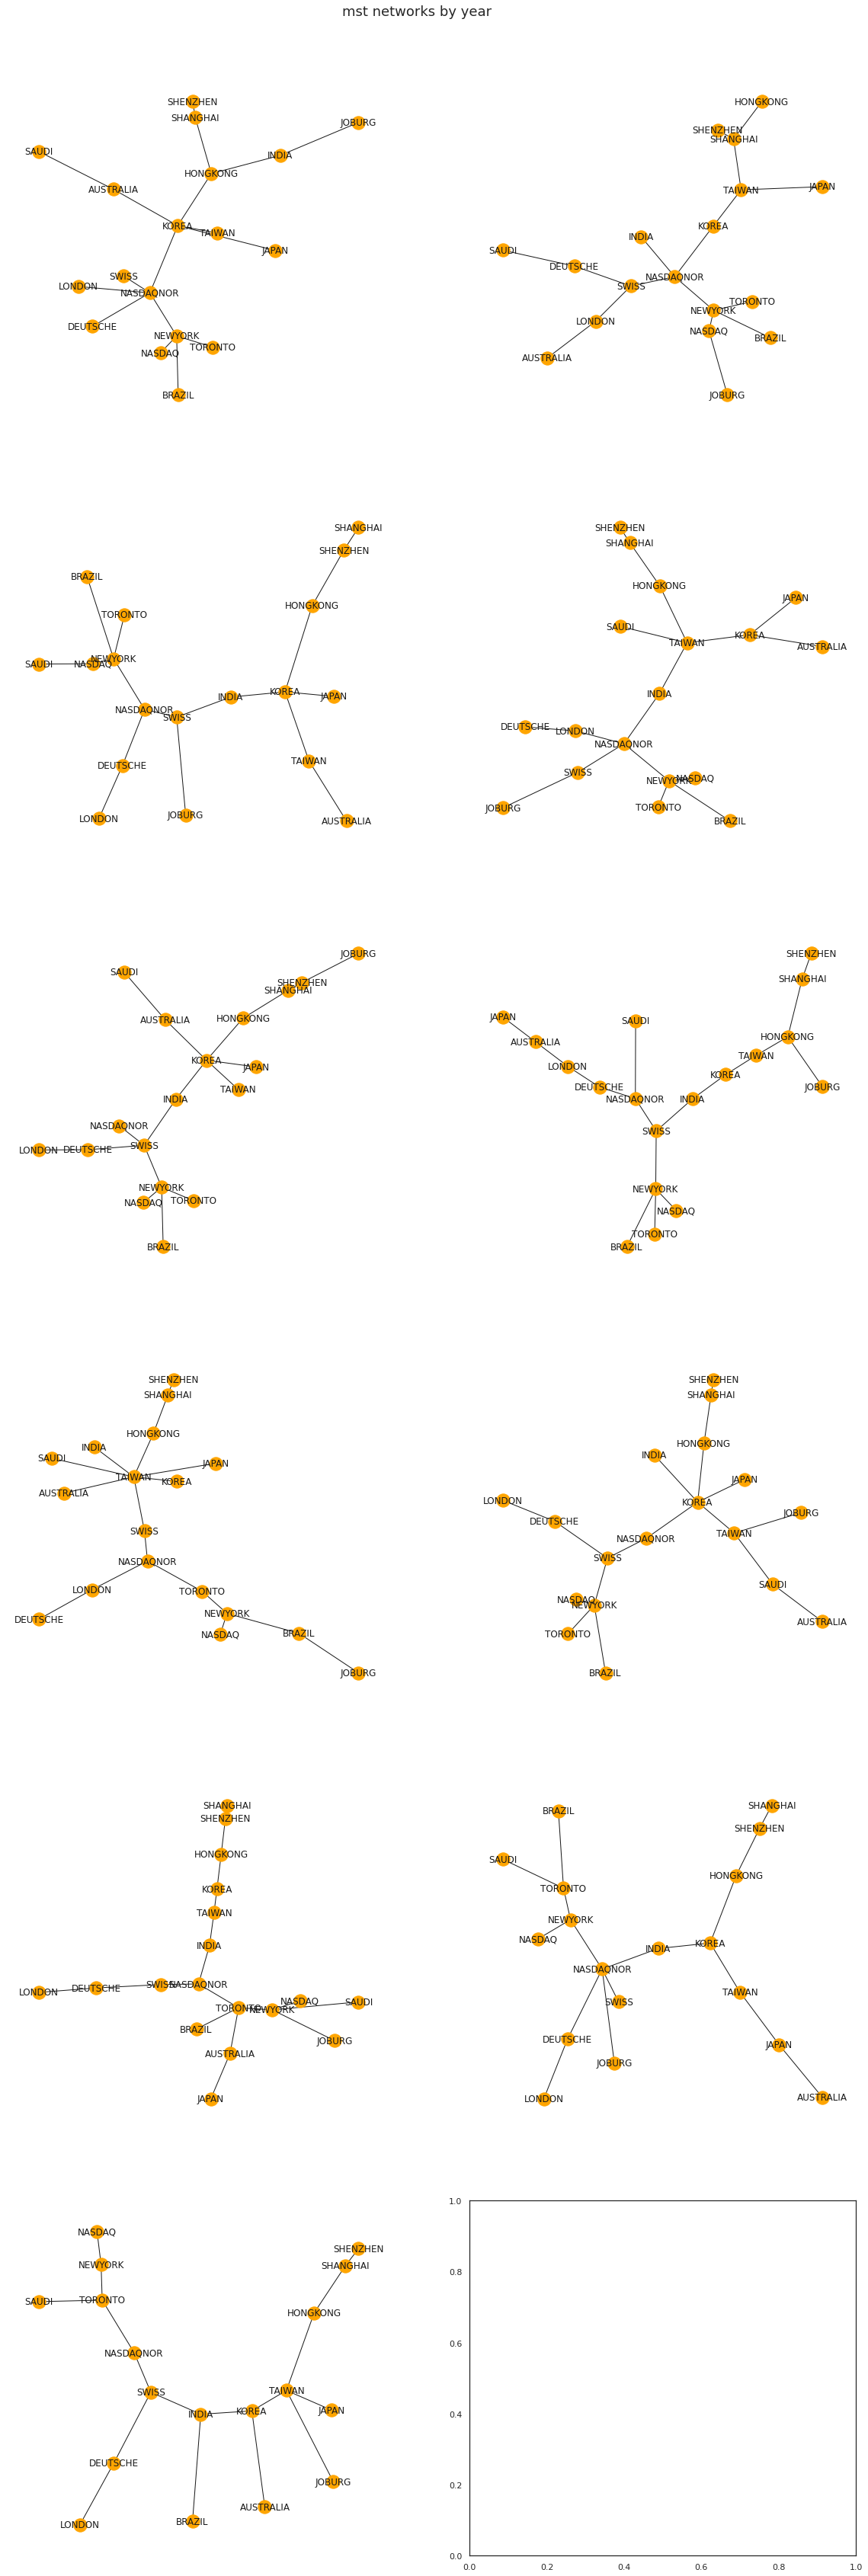

In [33]:
# and, finally, display the minimum spanning trees

fig, axes = plt.subplots(6, 2, figsize=(20, 60))

nx.draw_kamada_kawai(mst_2012, with_labels=True, node_color='orange', ax=axes[0, 0])
nx.draw_kamada_kawai(mst_2013, with_labels=True, node_color='orange', ax=axes[0, 1])
nx.draw_kamada_kawai(mst_2014, with_labels=True, node_color='orange', ax=axes[1, 0])
nx.draw_kamada_kawai(mst_2015, with_labels=True, node_color='orange', ax=axes[1, 1])
nx.draw_kamada_kawai(mst_2016, with_labels=True, node_color='orange', ax=axes[2, 0])
nx.draw_kamada_kawai(mst_2017, with_labels=True, node_color='orange', ax=axes[2, 1])
nx.draw_kamada_kawai(mst_2018, with_labels=True, node_color='orange', ax=axes[3, 0])
nx.draw_kamada_kawai(mst_2019, with_labels=True, node_color='orange', ax=axes[3, 1])
nx.draw_kamada_kawai(mst_2020, with_labels=True, node_color='orange', ax=axes[4, 0])
nx.draw_kamada_kawai(mst_2021, with_labels=True, node_color='orange', ax=axes[4, 1])
nx.draw_kamada_kawai(mst_2022, with_labels=True, node_color='orange', ax=axes[5, 0])

fig.suptitle('mst networks by year', y=0.9, fontsize=18)

plt.show()

In [34]:
# let's set some colours and make it easier to spot london and other european markets

# create an empty list
colours = []

# assign colours to markets
for node in mst_2012:
  if (node == "LONDON"):
    colours.append('orange')
  elif (node == "DEUTSCHE" or node == "SWISS" or node == "NASDAQNOR"):
    colours.append('lightblue')
  else:
    colours.append('lightgrey')

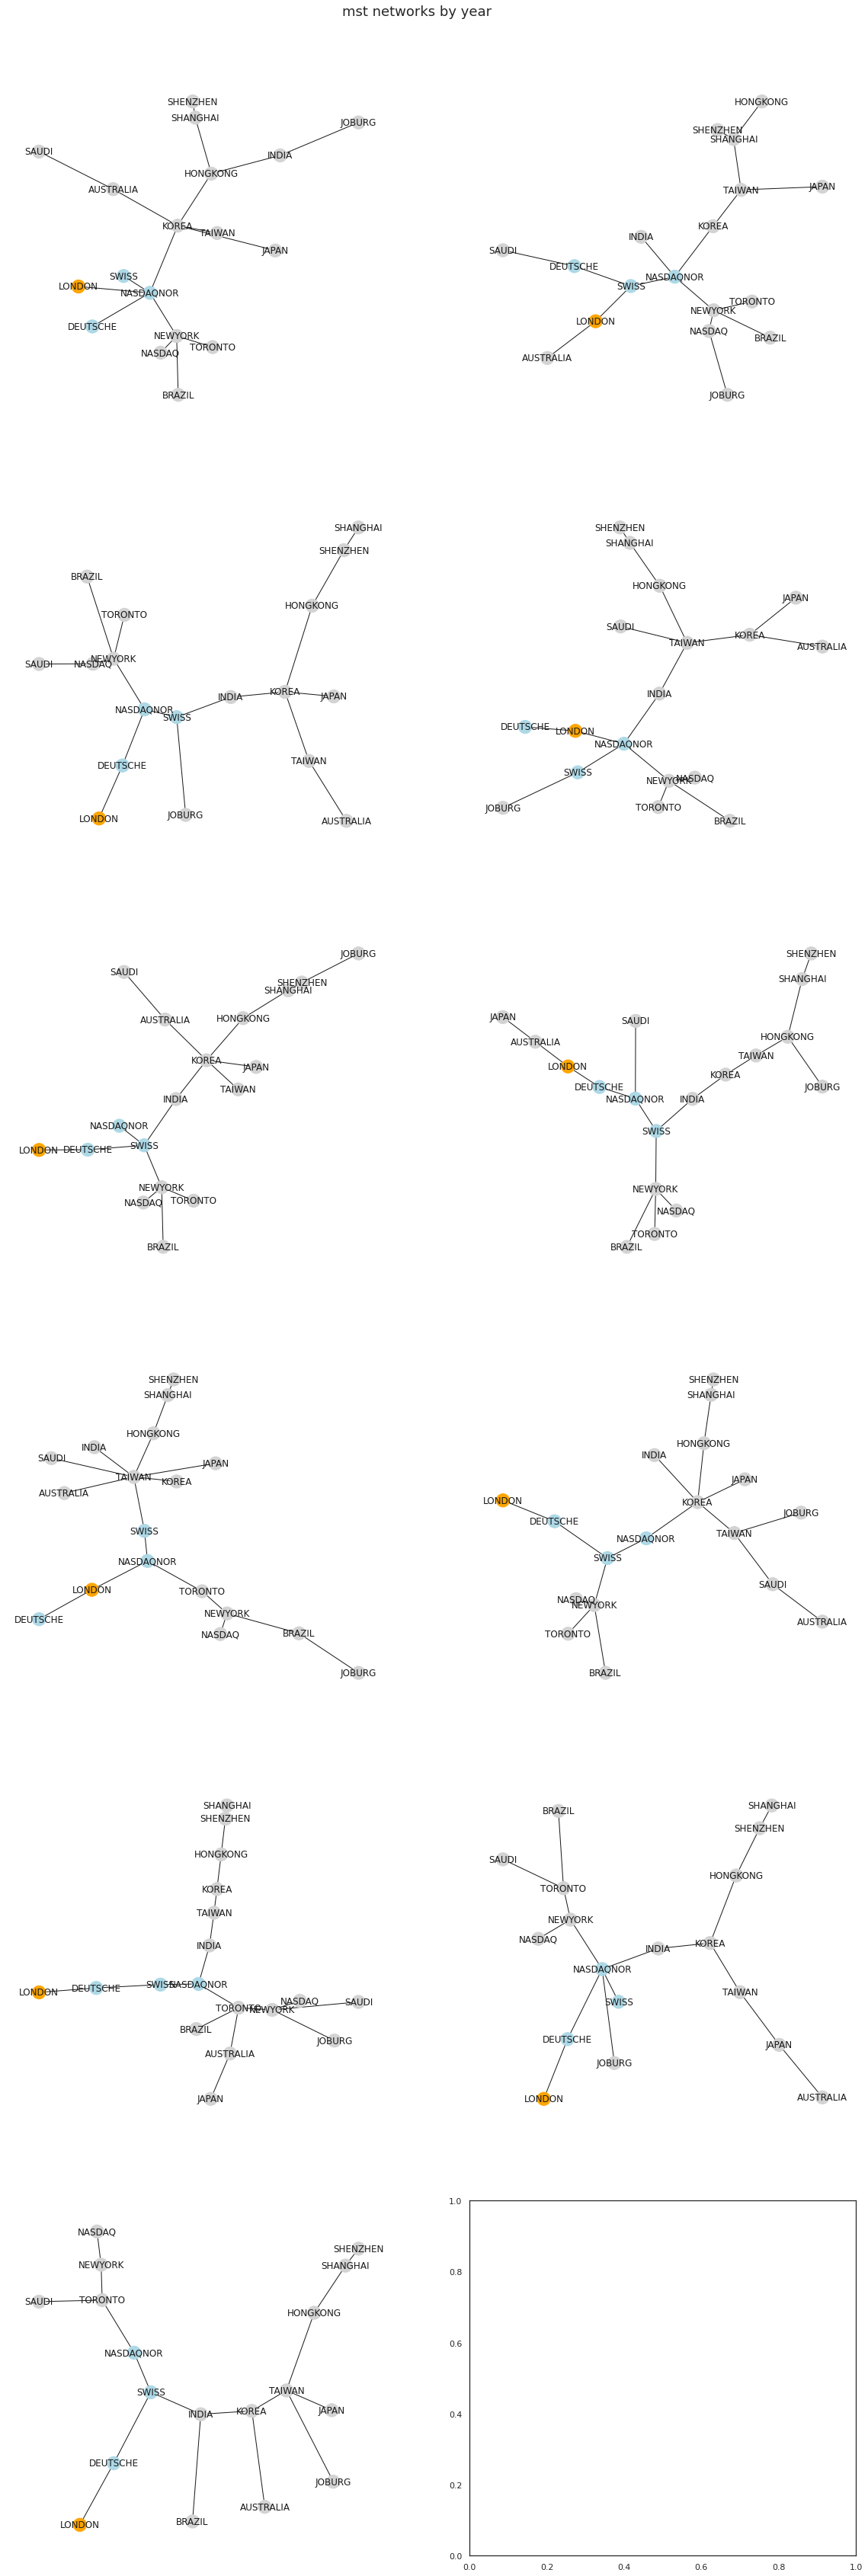

In [35]:
# display the minimum spanning trees again, but now with the colours we just set

fig, axes = plt.subplots(6, 2, figsize=(20, 60))

nx.draw_kamada_kawai(mst_2012, with_labels=True, node_color=colours, ax=axes[0, 0])
nx.draw_kamada_kawai(mst_2013, with_labels=True, node_color=colours, ax=axes[0, 1])
nx.draw_kamada_kawai(mst_2014, with_labels=True, node_color=colours, ax=axes[1, 0])
nx.draw_kamada_kawai(mst_2015, with_labels=True, node_color=colours, ax=axes[1, 1])
nx.draw_kamada_kawai(mst_2016, with_labels=True, node_color=colours, ax=axes[2, 0])
nx.draw_kamada_kawai(mst_2017, with_labels=True, node_color=colours, ax=axes[2, 1])
nx.draw_kamada_kawai(mst_2018, with_labels=True, node_color=colours, ax=axes[3, 0])
nx.draw_kamada_kawai(mst_2019, with_labels=True, node_color=colours, ax=axes[3, 1])
nx.draw_kamada_kawai(mst_2020, with_labels=True, node_color=colours, ax=axes[4, 0])
nx.draw_kamada_kawai(mst_2021, with_labels=True, node_color=colours, ax=axes[4, 1])
nx.draw_kamada_kawai(mst_2022, with_labels=True, node_color=colours, ax=axes[5, 0])

fig.suptitle('mst networks by year', y=0.9, fontsize=18)

plt.show()

## **3. CALCULATING STATISTICS**

Now we are ready to calculate four Network Analysis measures: degree centrality, betweenness centrality, closeness centrality, and eigenvector centrality. They measure a node’s importance, but each has a different emphasis. The article explains and has examples.

### **Degree centrality**

Degree centrality is the simplest measure: it is the number of connections expressed as a fraction of the total possible connections.  A node with a high degree centrality influences the behaviour of many others.

In [36]:
# we want to calculate degree centrality for every year's graph
# create a list of the graphs so that we don't have to type it out every time
graphs = [mst_2012, mst_2013, mst_2014, mst_2015, mst_2016, mst_2017, mst_2018, mst_2019, mst_2020, mst_2021, mst_2022]

In [37]:
# calculate degree centrality

# initialise an empty list
degree_cen = []

# calculate degree centrality for each year and append it to the empty list
for graph in graphs:
  degree_cen.append(nx.degree_centrality(graph))

In [38]:
# the result is a list of dictionaries
degree_cen

[{'NEWYORK': 0.23529411764705882,
  'NASDAQ': 0.058823529411764705,
  'SHANGHAI': 0.11764705882352941,
  'JAPAN': 0.058823529411764705,
  'SHENZHEN': 0.058823529411764705,
  'HONGKONG': 0.1764705882352941,
  'INDIA': 0.11764705882352941,
  'SAUDI': 0.058823529411764705,
  'LONDON': 0.058823529411764705,
  'TORONTO': 0.058823529411764705,
  'SWISS': 0.058823529411764705,
  'DEUTSCHE': 0.058823529411764705,
  'NASDAQNOR': 0.29411764705882354,
  'AUSTRALIA': 0.11764705882352941,
  'KOREA': 0.29411764705882354,
  'TAIWAN': 0.058823529411764705,
  'JOBURG': 0.058823529411764705,
  'BRAZIL': 0.058823529411764705},
 {'NEWYORK': 0.23529411764705882,
  'NASDAQ': 0.11764705882352941,
  'SHANGHAI': 0.1764705882352941,
  'JAPAN': 0.058823529411764705,
  'SHENZHEN': 0.058823529411764705,
  'HONGKONG': 0.058823529411764705,
  'INDIA': 0.058823529411764705,
  'SAUDI': 0.058823529411764705,
  'LONDON': 0.11764705882352941,
  'TORONTO': 0.058823529411764705,
  'SWISS': 0.1764705882352941,
  'DEUTSCHE':

In [39]:
# convert the list of dictionaries to dataframe
df_degree = pd.DataFrame(degree_cen)

# add years in the first column
df_degree.insert(0, 'YEAR', years)

In [40]:
# and check the resulting dataframe
df_degree

YEAR   NEWYORK    NASDAQ  SHANGHAI     JAPAN  SHENZHEN  HONGKONG  \
0   2012  0.235294  0.058824  0.117647  0.058824  0.058824  0.176471   
1   2013  0.235294  0.117647  0.176471  0.058824  0.058824  0.058824   
2   2014  0.235294  0.117647  0.058824  0.058824  0.117647  0.117647   
3   2015  0.235294  0.058824  0.117647  0.058824  0.058824  0.117647   
4   2016  0.235294  0.058824  0.117647  0.058824  0.117647  0.117647   
5   2017  0.235294  0.058824  0.117647  0.058824  0.058824  0.176471   
6   2018  0.176471  0.058824  0.117647  0.058824  0.058824  0.117647   
7   2019  0.235294  0.058824  0.117647  0.058824  0.058824  0.117647   
8   2020  0.235294  0.058824  0.058824  0.058824  0.117647  0.117647   
9   2021  0.176471  0.058824  0.058824  0.117647  0.117647  0.117647   
10  2022  0.117647  0.058824  0.117647  0.058824  0.058824  0.117647   

       INDIA     SAUDI    LONDON   TORONTO     SWISS  DEUTSCHE  NASDAQNOR  \
0   0.117647  0.058824  0.058824  0.058824  0.058824  0.058824   0.294118   
1   0.058824  0.058824  0.117647  0.058824  0.176471  0.117647   0.235294   
2   0.117647  0.058824  0.058824  0.058824  0.176471  0.117647   0.176471   
3   0.117647  0.058824  0.117647  0.058824  0.117647  0.058824   0.235294   
4   0.117647  0.058824  0.058824  0.058824  0.235294  0.117647   0.058824   
5   0.117647  0.058824  0.117647  0.058824  0.176471  0.117647   0.176471   
6   0.058824  0.058824  0.117647  0.117647  0.117647  0.058824   0.176471   
7   0.058824  0.117647  0.058824  0.058824  0.176471  0.117647   0.117647   
8   0.117647  0.058824  0.058824  0.235294  0.117647  0.117647   0.176471   
9   0.117647  0.058824  0.058824  0.176471  0.058824  0.117647   0.294118   
10  0.176471  0.058824  0.058824  0.176471  0.176471  0.117647   0.117647   

    AUSTRALIA     KOREA    TAIWAN    JOBURG    BRAZIL  
0    0.117647  0.294118  0.058824  0.058824  0.058824  
1    0.058824  0.117647  0.176471  0.058824  0.058824  
2    0.058824  0.235294  0.117647  0.058824  0.058824  
3    0.058824  0.176471  0.235294  0.058824  0.058824  
4    0.117647  0.294118  0.058824  0.058824  0.058824  
5    0.117647  0.117647  0.117647  0.058824  0.058824  
6    0.058824  0.058824  0.411765  0.058824  0.117647  
7    0.058824  0.294118  0.176471  0.058824  0.058824  
8    0.117647  0.117647  0.117647  0.058824  0.058824  
9    0.058824  0.176471  0.117647  0.058824  0.058824  
10   0.058824  0.176471  0.235294  0.058824  0.058824

In [41]:
# check distributions - New York, Nasdaq Nordic, and Korea have the highest means
df_degree.describe().T.sort_values(by='mean', ascending=False)

count      mean           std       min       25%       50%  \
NEWYORK     11.0  0.213904  3.965882e-02  0.117647  0.205882  0.235294   
KOREA       11.0  0.187166  8.242930e-02  0.058824  0.117647  0.176471   
NASDAQNOR   11.0  0.187166  7.355614e-02  0.058824  0.147059  0.176471   
TAIWAN      11.0  0.165775  1.012660e-01  0.058824  0.117647  0.117647   
SWISS       11.0  0.144385  5.495287e-02  0.058824  0.117647  0.176471   
HONGKONG    11.0  0.122995  3.172705e-02  0.058824  0.117647  0.117647   
SHANGHAI    11.0  0.106952  3.547192e-02  0.058824  0.088235  0.117647   
INDIA       11.0  0.106952  3.547192e-02  0.058824  0.088235  0.117647   
DEUTSCHE    11.0  0.101604  2.747643e-02  0.058824  0.088235  0.117647   
TORONTO     11.0  0.101604  6.492428e-02  0.058824  0.058824  0.058824   
LONDON      11.0  0.080214  2.967794e-02  0.058824  0.058824  0.058824   
AUSTRALIA   11.0  0.080214  2.967794e-02  0.058824  0.058824  0.058824   
SHENZHEN    11.0  0.080214  2.967794e-02  0.058824  0.058824  0.058824   
NASDAQ      11.0  0.069519  2.379529e-02  0.058824  0.058824  0.058824   
JAPAN       11.0  0.064171  1.773596e-02  0.058824  0.058824  0.058824   
SAUDI       11.0  0.064171  1.773596e-02  0.058824  0.058824  0.058824   
BRAZIL      11.0  0.064171  1.773596e-02  0.058824  0.058824  0.058824   
JOBURG      11.0  0.058824  7.277573e-18  0.058824  0.058824  0.058824   

                75%       max  
NEWYORK    0.235294  0.235294  
KOREA      0.264706  0.294118  
NASDAQNOR  0.235294  0.294118  
TAIWAN     0.205882  0.411765  
SWISS      0.176471  0.235294  
HONGKONG   0.117647  0.176471  
SHANGHAI   0.117647  0.176471  
INDIA      0.117647  0.176471  
DEUTSCHE   0.117647  0.117647  
TORONTO    0.147059  0.235294  
LONDON     0.117647  0.117647  
AUSTRALIA  0.117647  0.117647  
SHENZHEN   0.117647  0.117647  
NASDAQ     0.058824  0.117647  
JAPAN      0.058824  0.117647  
SAUDI      0.058824  0.117647  
BRAZIL     0.058824  0.117647  
JOBURG     0.058824  0.058824

In [42]:
# let's look at the data in a line plot - we create a separate dataframe where we set year as the index so that we get the x-axis for the graph
df_degree_year_index = df_degree
df_degree_year_index.set_index('YEAR', inplace=True)

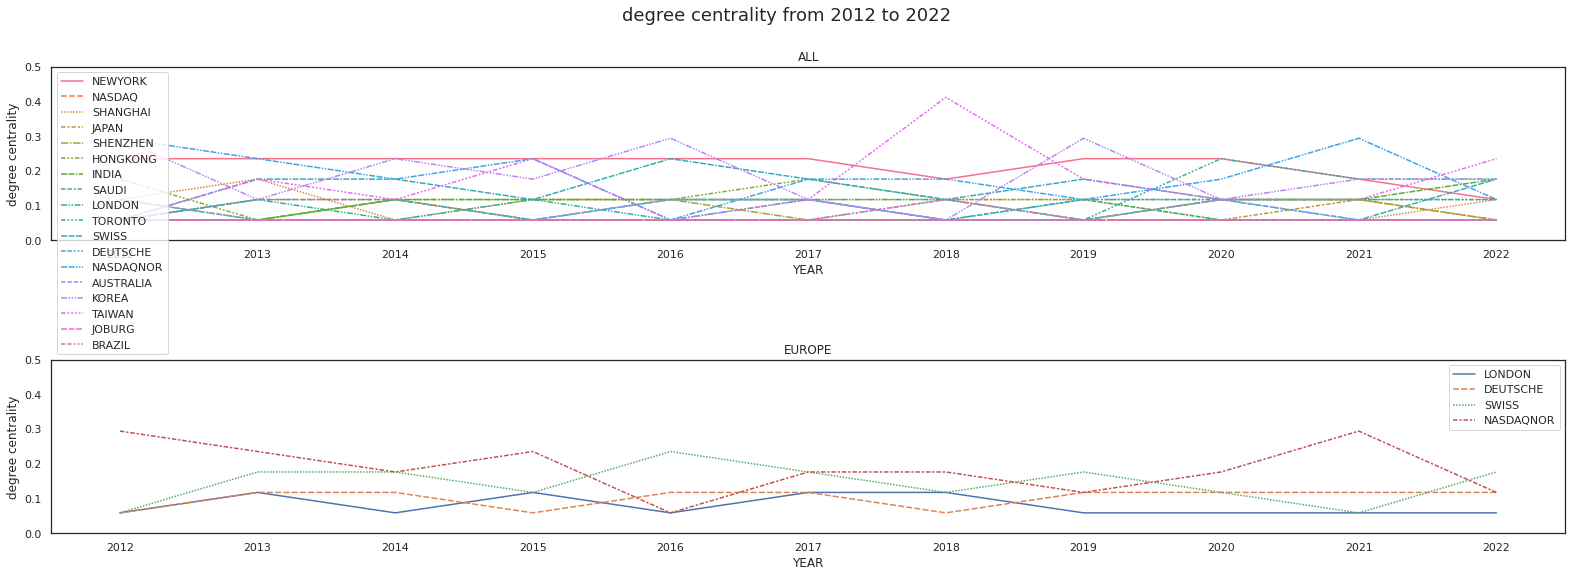

In [43]:
# now display the graph - line plots can be difficult to read, so we create two subplots
# one subplot shows all the markets, and the other focuses on Europe

# set figure
fig, axes = plt.subplots(2, 1, figsize=(22, 8))
sns.lineplot(data=df_degree_year_index, ax=axes[0]).set_title('ALL');
sns.lineplot(data=df_degree_year_index[['LONDON', 'DEUTSCHE', 'SWISS', 'NASDAQNOR']], ax=axes[1]).set_title('EUROPE');

# set same ylim for both subplots
cust_ylim = (0, 0.5)
plt.setp(axes, ylim=cust_ylim)

# move legend to upper left
axes[0].legend(loc="upper left")
axes[1].legend(loc="upper right")

# set ylabels
axes[0].set_ylabel('degree centrality')
axes[1].set_ylabel('degree centrality')

fig.suptitle('degree centrality from 2012 to 2022', y=1, fontsize=18)
fig.tight_layout()

plt.show()

### **Betweenness centrality**

In [44]:
# now do the same for betweenness centrality

# initialise an empty list
betweenness_cen = []

# calculate degree centrality for each year and append it to the empty list
for graph in graphs:
  betweenness_cen.append(nx.betweenness_centrality(graph))

In [45]:
# convert the list of dictionaries to a dataframe
df_betweenness = pd.DataFrame(betweenness_cen)

# and add years in the first column
df_betweenness.insert(0, 'YEAR', years)

In [46]:
# check the result - every terminal node has score zero because it is not in between any two nodes, so we should expect quite a few zeros
df_betweenness

YEAR   NEWYORK    NASDAQ  SHANGHAI     JAPAN  SHENZHEN  HONGKONG  \
0   2012  0.330882  0.000000  0.117647  0.000000  0.000000  0.411765   
1   2013  0.419118  0.117647  0.227941  0.000000  0.000000  0.000000   
2   2014  0.419118  0.117647  0.000000  0.000000  0.117647  0.220588   
3   2015  0.330882  0.000000  0.117647  0.000000  0.000000  0.220588   
4   2016  0.330882  0.000000  0.220588  0.000000  0.117647  0.308824   
5   2017  0.330882  0.000000  0.117647  0.000000  0.000000  0.323529   
6   2018  0.323529  0.000000  0.117647  0.000000  0.000000  0.220588   
7   2019  0.330882  0.000000  0.117647  0.000000  0.000000  0.220588   
8   2020  0.330882  0.000000  0.000000  0.000000  0.117647  0.220588   
9   2021  0.404412  0.000000  0.000000  0.117647  0.117647  0.220588   
10  2022  0.117647  0.000000  0.117647  0.000000  0.000000  0.220588   

       INDIA     SAUDI    LONDON   TORONTO     SWISS  DEUTSCHE  NASDAQNOR  \
0   0.117647  0.000000  0.000000  0.000000  0.000000  0.000000   0.625000   
1   0.000000  0.000000  0.117647  0.000000  0.411765  0.117647   0.742647   
2   0.514706  0.000000  0.000000  0.000000  0.588235  0.117647   0.588235   
3   0.529412  0.000000  0.117647  0.000000  0.117647  0.000000   0.676471   
4   0.529412  0.000000  0.000000  0.000000  0.617647  0.117647   0.000000   
5   0.485294  0.000000  0.220588  0.000000  0.691176  0.308824   0.470588   
6   0.000000  0.000000  0.117647  0.382353  0.529412  0.000000   0.588235   
7   0.000000  0.117647  0.000000  0.000000  0.544118  0.117647   0.514706   
8   0.441176  0.000000  0.000000  0.617647  0.220588  0.117647   0.661765   
9   0.514706  0.000000  0.000000  0.227941  0.000000  0.117647   0.713235   
10  0.588235  0.000000  0.000000  0.323529  0.588235  0.117647   0.382353   

    AUSTRALIA     KOREA    TAIWAN  JOBURG    BRAZIL  
0    0.117647  0.713235  0.000000     0.0  0.000000  
1    0.000000  0.441176  0.404412     0.0  0.000000  
2    0.000000  0.566176  0.117647     0.0  0.000000  
3    0.000000  0.227941  0.625000     0.0  0.000000  
4    0.117647  0.683824  0.000000     0.0  0.000000  
5    0.117647  0.441176  0.382353     0.0  0.000000  
6    0.000000  0.000000  0.713235     0.0  0.117647  
7    0.000000  0.727941  0.323529     0.0  0.000000  
8    0.117647  0.308824  0.382353     0.0  0.000000  
9    0.000000  0.551471  0.220588     0.0  0.000000  
10   0.000000  0.558824  0.492647     0.0  0.000000

In [47]:
# check distributions - Nasdaq Nordic and Korea have the highest averages globally, followed at a small distance by Swiss, India, New York, and Taiwan
df_betweenness.describe().T.sort_values(by='mean', ascending=False)

count      mean       std       min       25%       50%       75%  \
NASDAQNOR   11.0  0.542112  0.209348  0.000000  0.492647  0.588235  0.669118   
KOREA       11.0  0.474599  0.224075  0.000000  0.375000  0.551471  0.625000   
SWISS       11.0  0.391711  0.259197  0.000000  0.169118  0.529412  0.588235   
INDIA       11.0  0.338235  0.249394  0.000000  0.058824  0.485294  0.522059   
NEWYORK     11.0  0.333556  0.081500  0.117647  0.330882  0.330882  0.367647   
TAIWAN      11.0  0.332888  0.233705  0.000000  0.169118  0.382353  0.448529   
HONGKONG    11.0  0.235294  0.100604  0.000000  0.220588  0.220588  0.264706   
TORONTO     11.0  0.141043  0.215751  0.000000  0.000000  0.000000  0.275735   
SHANGHAI    11.0  0.104947  0.079063  0.000000  0.058824  0.117647  0.117647   
DEUTSCHE    11.0  0.102941  0.087001  0.000000  0.058824  0.117647  0.117647   
LONDON      11.0  0.052139  0.077639  0.000000  0.000000  0.000000  0.117647   
SHENZHEN    11.0  0.042781  0.059356  0.000000  0.000000  0.000000  0.117647   
AUSTRALIA   11.0  0.042781  0.059356  0.000000  0.000000  0.000000  0.117647   
NASDAQ      11.0  0.021390  0.047591  0.000000  0.000000  0.000000  0.000000   
SAUDI       11.0  0.010695  0.035472  0.000000  0.000000  0.000000  0.000000   
JAPAN       11.0  0.010695  0.035472  0.000000  0.000000  0.000000  0.000000   
BRAZIL      11.0  0.010695  0.035472  0.000000  0.000000  0.000000  0.000000   
JOBURG      11.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

                max  
NASDAQNOR  0.742647  
KOREA      0.727941  
SWISS      0.691176  
INDIA      0.588235  
NEWYORK    0.419118  
TAIWAN     0.713235  
HONGKONG   0.411765  
TORONTO    0.617647  
SHANGHAI   0.227941  
DEUTSCHE   0.308824  
LONDON     0.220588  
SHENZHEN   0.117647  
AUSTRALIA  0.117647  
NASDAQ     0.117647  
SAUDI      0.117647  
JAPAN      0.117647  
BRAZIL     0.117647  
JOBURG     0.000000

In [48]:
# create a new dataframe with year as the index for our graphs
df_betweenness_year_index = df_betweenness
df_betweenness_year_index.set_index("YEAR", inplace=True)

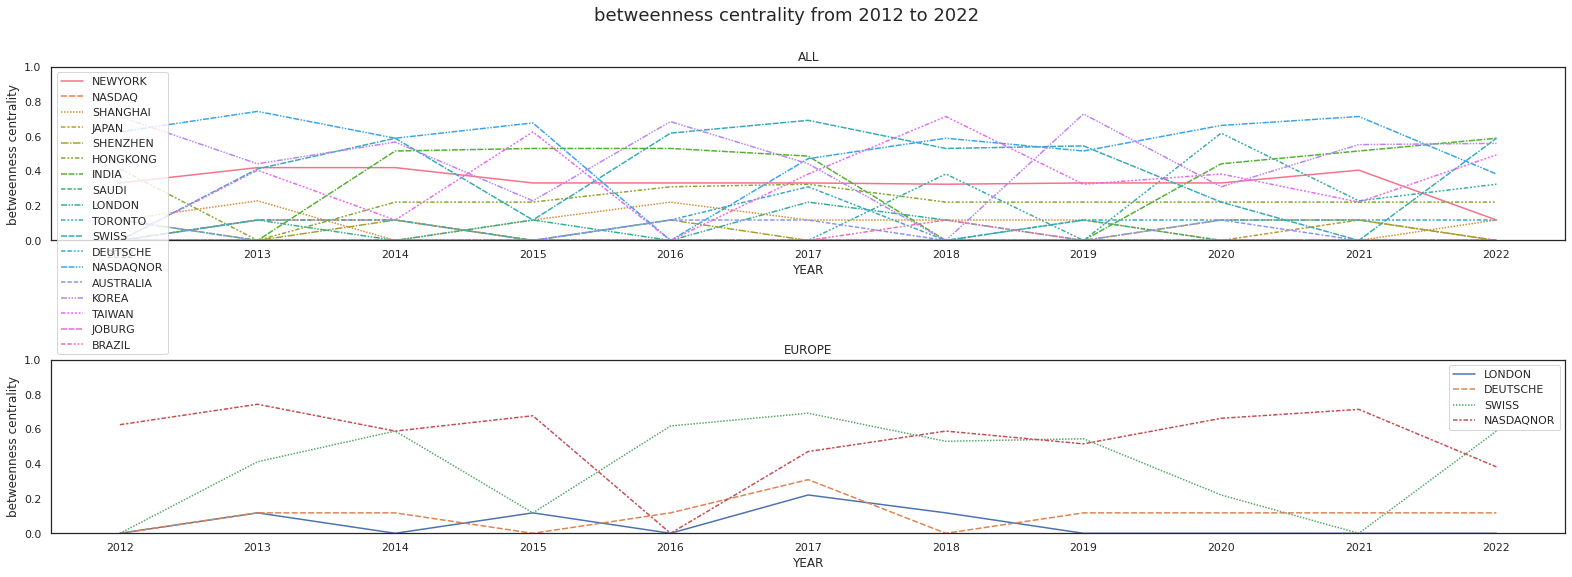

In [49]:
# and visualise the results

# set figure
fig, axes = plt.subplots(2, 1, figsize=(22, 8))
sns.lineplot(data=df_betweenness_year_index, ax=axes[0]).set_title('ALL');
sns.lineplot(data=df_betweenness_year_index[['LONDON', 'DEUTSCHE', 'SWISS', 'NASDAQNOR']], ax=axes[1]).set_title('EUROPE');

# set same ylim for both subplots
cust_ylim = (0, 1)
plt.setp(axes, ylim=cust_ylim)

# move legend to upper left
axes[0].legend(loc="upper left")
axes[1].legend(loc="upper right")

# set ylabels
axes[0].set_ylabel('betweenness centrality')
axes[1].set_ylabel('betweenness centrality')

fig.suptitle('betweenness centrality from 2012 to 2022', y=1, fontsize=18)
fig.tight_layout()

plt.show()

### **Closeness centrality**

In [50]:
# then closeness centrality

# initialise an empty list
closeness_cen = []

# calculate closeness centrality for each year and append it to the empty list
for graph in graphs:
  closeness_cen.append(nx.closeness_centrality(graph))

In [51]:
# convert the list of dictionaries to a dataframe
df_closeness = pd.DataFrame(closeness_cen)

# and add years in the first column
df_closeness.insert(0, 'YEAR', years)

In [52]:
# let's check the result
df_closeness

YEAR   NEWYORK    NASDAQ  SHANGHAI     JAPAN  SHENZHEN  HONGKONG  \
0   2012  0.369565  0.274194  0.303571  0.340000  0.236111  0.404762   
1   2013  0.361702  0.278689  0.261538  0.246377  0.209877  0.209877   
2   2014  0.298246  0.239437  0.178947  0.246377  0.215190  0.261538   
3   2015  0.326923  0.250000  0.242857  0.236111  0.197674  0.303571   
4   2016  0.309091  0.239437  0.261538  0.288136  0.215190  0.320755   
5   2017  0.283333  0.223684  0.184783  0.157407  0.157407  0.217949   
6   2018  0.265625  0.212500  0.242857  0.283333  0.197674  0.303571   
7   2019  0.298246  0.232877  0.253731  0.298246  0.204819  0.320755   
8   2020  0.293103  0.229730  0.151786  0.217949  0.177083  0.207317   
9   2021  0.333333  0.253731  0.186813  0.226667  0.226667  0.278689   
10  2022  0.207317  0.173469  0.207317  0.236111  0.173469  0.250000   

       INDIA     SAUDI    LONDON   TORONTO     SWISS  DEUTSCHE  NASDAQNOR  \
0   0.303571  0.265625  0.326923  0.274194  0.326923  0.326923   0.472222   
1   0.309091  0.220779  0.278689  0.269841  0.361702  0.278689   0.435897   
2   0.346939  0.195402  0.215190  0.232877  0.361702  0.269841   0.346939   
3   0.404762  0.283333  0.303571  0.250000  0.303571  0.236111   0.404762   
4   0.395349  0.232877  0.226667  0.239437  0.377778  0.288136   0.278689   
5   0.314815  0.236111  0.217949  0.223684  0.340000  0.257576   0.303571   
6   0.283333  0.283333  0.283333  0.314815  0.386364  0.223684   0.369565   
7   0.298246  0.261538  0.220779  0.232877  0.361702  0.278689   0.395349   
8   0.326923  0.229730  0.193182  0.354167  0.293103  0.236111   0.369565   
9   0.377778  0.215190  0.232877  0.269841  0.288136  0.298246   0.395349   
10  0.354167  0.202381  0.212500  0.250000  0.340000  0.265625   0.293103   

    AUSTRALIA     KOREA    TAIWAN    JOBURG    BRAZIL  
0    0.354167  0.500000  0.340000  0.236111  0.274194  
1    0.220779  0.377778  0.320755  0.220779  0.269841  
2    0.204819  0.320755  0.253731  0.269841  0.232877  
3    0.236111  0.303571  0.386364  0.236111  0.250000  
4    0.298246  0.395349  0.288136  0.178947  0.239437  
5    0.184783  0.283333  0.250000  0.180851  0.223684  
6    0.283333  0.283333  0.386364  0.180851  0.217949  
7    0.209877  0.414634  0.333333  0.253731  0.232877  
8    0.274194  0.242857  0.283333  0.229730  0.265625  
9    0.186813  0.346939  0.278689  0.288136  0.215190  
10   0.257576  0.340000  0.303571  0.236111  0.265625

In [53]:
# check distributions - Nasdaq Nordic, Korea, Swiss, India, Taiwan and New York are at the top, with average scores not far apart
df_closeness.describe().T.sort_values(by='mean', ascending=False)

count      mean       std       min       25%       50%       75%  \
NASDAQNOR   11.0  0.369547  0.060398  0.278689  0.325255  0.369565  0.400055   
KOREA       11.0  0.346232  0.072690  0.242857  0.293452  0.340000  0.386563   
SWISS       11.0  0.340089  0.033730  0.288136  0.315247  0.340000  0.361702   
INDIA       11.0  0.337725  0.041133  0.283333  0.306331  0.326923  0.365972   
TAIWAN      11.0  0.311298  0.047097  0.250000  0.281011  0.303571  0.336667   
NEWYORK     11.0  0.304226  0.045246  0.207317  0.288218  0.298246  0.330128   
HONGKONG    11.0  0.279889  0.059407  0.207317  0.233974  0.278689  0.312163   
DEUTSCHE    11.0  0.269057  0.030206  0.223684  0.246843  0.269841  0.283412   
TORONTO     11.0  0.264703  0.039290  0.223684  0.236157  0.250000  0.272017   
JAPAN       11.0  0.252428  0.048462  0.157407  0.231389  0.246377  0.285734   
LONDON      11.0  0.246514  0.043764  0.193182  0.216569  0.226667  0.281011   
AUSTRALIA   11.0  0.246427  0.052665  0.184783  0.207348  0.236111  0.278763   
BRAZIL      11.0  0.244300  0.021770  0.215190  0.228280  0.239437  0.265625   
SAUDI       11.0  0.238755  0.030691  0.195402  0.217985  0.232877  0.263582   
NASDAQ      11.0  0.237068  0.029096  0.173469  0.226707  0.239437  0.251866   
JOBURG      11.0  0.228291  0.036239  0.178947  0.200815  0.236111  0.244921   
SHANGHAI    11.0  0.225067  0.046018  0.151786  0.185798  0.242857  0.257635   
SHENZHEN    11.0  0.201015  0.023749  0.157407  0.187379  0.204819  0.215190   

                max  
NASDAQNOR  0.472222  
KOREA      0.500000  
SWISS      0.386364  
INDIA      0.404762  
TAIWAN     0.386364  
NEWYORK    0.369565  
HONGKONG   0.404762  
DEUTSCHE   0.326923  
TORONTO    0.354167  
JAPAN      0.340000  
LONDON     0.326923  
AUSTRALIA  0.354167  
BRAZIL     0.274194  
SAUDI      0.283333  
NASDAQ     0.278689  
JOBURG     0.288136  
SHANGHAI   0.303571  
SHENZHEN   0.236111

In [54]:
# create a new dataframe with year as the index for our graphs
df_closeness_year_index = df_closeness
df_closeness_year_index.set_index("YEAR", inplace=True)

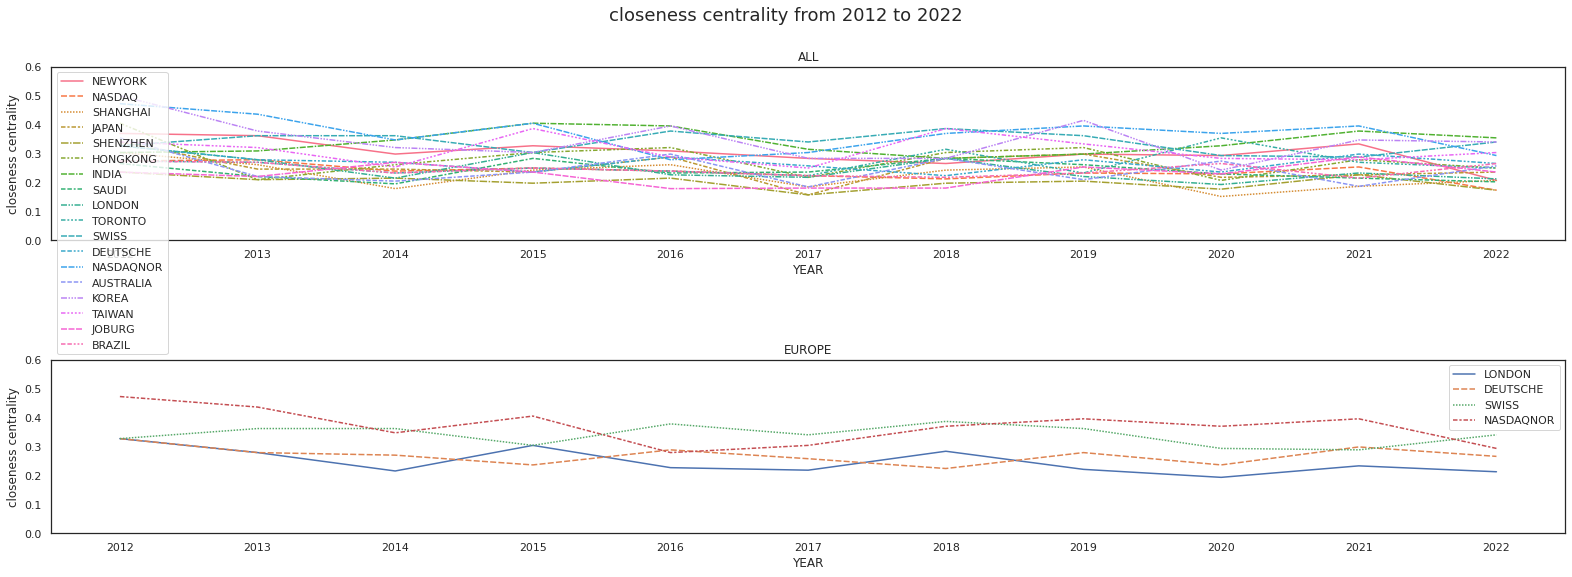

In [55]:
# and visualise the results

# set figure
fig, axes = plt.subplots(2, 1, figsize=(22, 8))
sns.lineplot(data=df_closeness_year_index, ax=axes[0]).set_title('ALL');
sns.lineplot(data=df_closeness_year_index[['LONDON', 'DEUTSCHE', 'SWISS', 'NASDAQNOR']], ax=axes[1]).set_title('EUROPE');

# set same ylim for both subplots
cust_ylim = (0, 0.6)
plt.setp(axes, ylim=cust_ylim)

# move legend to upper left
axes[0].legend(loc="upper left")
axes[1].legend(loc="upper right")

# set ylabels
axes[0].set_ylabel('closeness centrality')
axes[1].set_ylabel('closeness centrality')

fig.suptitle('closeness centrality from 2012 to 2022', y=1, fontsize=18)
fig.tight_layout()

plt.show()

### **Eigenvector centrality**

In [56]:
# and finally eigenvector centrality

# initialise an empty list
eigenvector_cen = []

# calculate eigenvector centrality for each year and append it to the emmpty list
for graph in graphs:
  eigenvector_cen.append(nx.eigenvector_centrality_numpy(graph))

In [57]:
# convert list to dataframe
df_eigenvector = pd.DataFrame(eigenvector_cen)

# and add years in the first column
df_eigenvector.insert(0, 'YEAR', years)

In [58]:
# let's have a look at the result
df_eigenvector

YEAR   NEWYORK    NASDAQ  SHANGHAI     JAPAN  SHENZHEN  HONGKONG  \
0   2012  0.319436  0.117702  0.116152  0.186833  0.042798  0.272429   
1   2013  0.450099  0.217573  0.121425  0.081718  0.049099  0.049099   
2   2014  0.423988  0.217652  0.038751  0.140150  0.091838  0.178901   
3   2015  0.396349  0.160537  0.089030  0.089030  0.036061  0.183744   
4   2016  0.320465  0.127858  0.120853  0.197343  0.057346  0.245561   
5   2017  0.490058  0.211476  0.042758  0.027726  0.018452  0.080634   
6   2018  0.039006  0.014309  0.124127  0.247314  0.045533  0.292847   
7   2019  0.209149  0.083691  0.136285  0.231514  0.054535  0.286049   
8   2020  0.451806  0.185166  0.005679  0.110406  0.013856  0.028130   
9   2021  0.396538  0.159032  0.020637  0.051457  0.051457  0.107669   
10  2022  0.071756  0.030457  0.130281  0.196342  0.055298  0.251640   

       INDIA     SAUDI    LONDON   TORONTO     SWISS  DEUTSCHE  NASDAQNOR  \
0   0.116152  0.079657  0.189326  0.117702  0.189326  0.189326   0.513818   
1   0.214937  0.068976  0.170583  0.181999  0.352890  0.170583   0.531557   
2   0.297623  0.091838  0.093006  0.178901  0.373203  0.220420   0.429380   
3   0.348960  0.147683  0.240778  0.160537  0.240778  0.097525   0.496930   
4   0.364770  0.093642  0.079446  0.127858  0.419639  0.199124   0.167427   
5   0.290787  0.164238  0.121163  0.211476  0.501198  0.216524   0.380594   
6   0.247314  0.247314  0.070697  0.075492  0.308498  0.025934   0.166792   
7   0.231514  0.169897  0.051780  0.083691  0.271601  0.129401   0.340196   
8   0.202726  0.185166  0.040336  0.546908  0.199810  0.098421   0.389117   
9   0.325762  0.094027  0.114094  0.234452  0.238730  0.284488   0.595260   
10  0.397893  0.058828  0.070990  0.138597  0.323048  0.167251   0.195947   

    AUSTRALIA     KOREA    TAIWAN    JOBURG    BRAZIL  
0    0.216184  0.507050  0.186833  0.042798  0.117702  
1    0.068976  0.296656  0.202096  0.087977  0.181999  
2    0.071945  0.332150  0.170508  0.157472  0.178901  
3    0.089030  0.219805  0.364614  0.097525  0.160537  
4    0.234704  0.494621  0.197343  0.022880  0.127858  
5    0.064250  0.172650  0.109300  0.034796  0.211476  
6    0.247314  0.247314  0.674197  0.006065  0.016533  
7    0.067984  0.578567  0.356597  0.142693  0.083691  
8    0.269391  0.054781  0.105536  0.185166  0.224143  
9    0.020637  0.217009  0.107669  0.238730  0.094027  
10   0.189089  0.445488  0.462575  0.196342  0.168887

In [59]:
# check distributions - Nasdaq Nordic has the highest average, followed by New York, Korea and the Swiss Market Index, which have similar scores
df_eigenvector.describe().T.sort_values(by='mean', ascending=False)

count      mean       std       min       25%       50%       75%  \
NASDAQNOR   11.0  0.382456  0.151475  0.166792  0.268071  0.389117  0.505374   
NEWYORK     11.0  0.324423  0.154394  0.039006  0.264292  0.396349  0.437044   
KOREA       11.0  0.324190  0.163269  0.054781  0.218407  0.296656  0.470055   
SWISS       11.0  0.310793  0.096243  0.189326  0.239754  0.308498  0.363046   
INDIA       11.0  0.276222  0.082870  0.116152  0.223226  0.290787  0.337361   
TAIWAN      11.0  0.267024  0.179651  0.105536  0.139904  0.197343  0.360606   
TORONTO     11.0  0.187056  0.129199  0.075492  0.122780  0.160537  0.196737   
HONGKONG    11.0  0.179700  0.098628  0.028130  0.094151  0.183744  0.262035   
DEUTSCHE    11.0  0.163545  0.071669  0.025934  0.113911  0.170583  0.207824   
BRAZIL      11.0  0.142341  0.061510  0.016533  0.105865  0.160537  0.180450   
JAPAN       11.0  0.141803  0.074717  0.027726  0.085374  0.140150  0.196842   
AUSTRALIA   11.0  0.139955  0.091042  0.020637  0.068480  0.089030  0.225444   
NASDAQ      11.0  0.138678  0.071815  0.014309  0.100697  0.159032  0.198321   
SAUDI       11.0  0.127388  0.059333  0.058828  0.085748  0.094027  0.167068   
LONDON      11.0  0.112927  0.062964  0.040336  0.070844  0.093006  0.145873   
JOBURG      11.0  0.110222  0.078869  0.006065  0.038797  0.097525  0.171319   
SHANGHAI    11.0  0.085998  0.049150  0.005679  0.040755  0.116152  0.122776   
SHENZHEN    11.0  0.046934  0.020785  0.013856  0.039430  0.049099  0.054916   

                max  
NASDAQNOR  0.595260  
NEWYORK    0.490058  
KOREA      0.578567  
SWISS      0.501198  
INDIA      0.397893  
TAIWAN     0.674197  
TORONTO    0.546908  
HONGKONG   0.292847  
DEUTSCHE   0.284488  
BRAZIL     0.224143  
JAPAN      0.247314  
AUSTRALIA  0.269391  
NASDAQ     0.217652  
SAUDI      0.247314  
LONDON     0.240778  
JOBURG     0.238730  
SHANGHAI   0.136285  
SHENZHEN   0.091838

In [60]:
# create a new dataframe with year as the index for our graphs
df_eigenvector_year_index = df_eigenvector
df_eigenvector_year_index.set_index("YEAR", inplace=True)

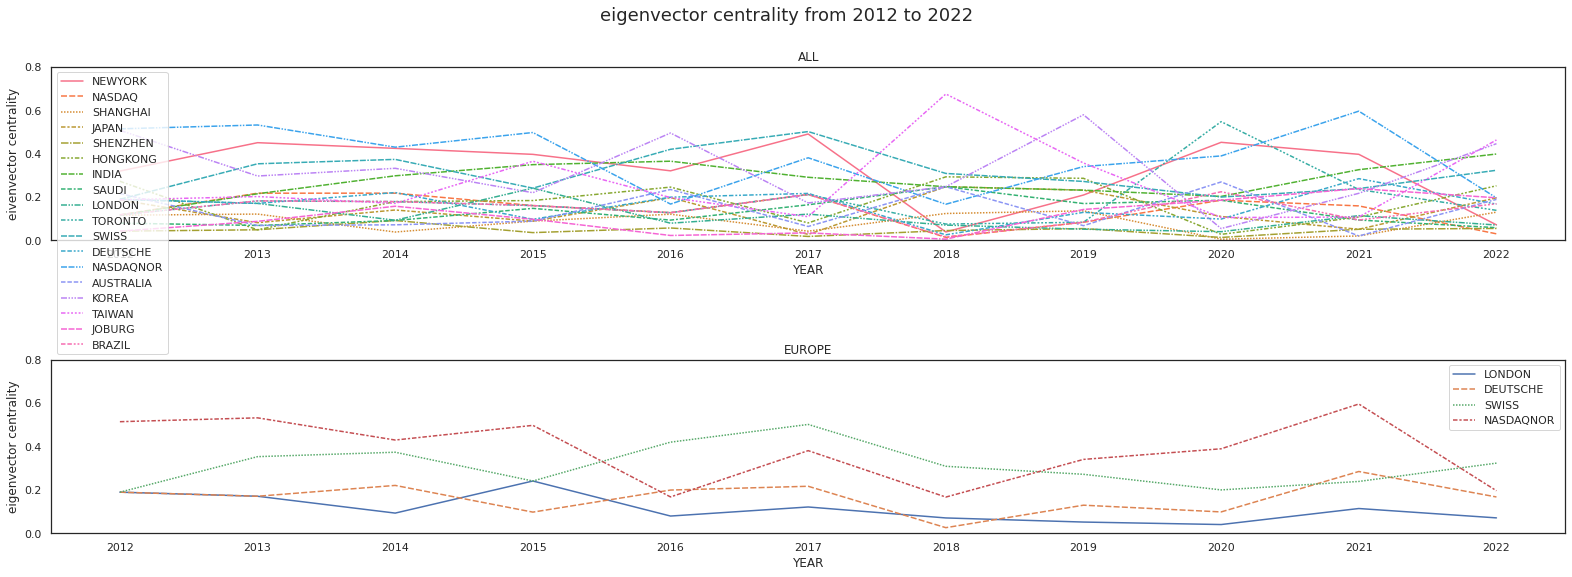

In [61]:
# and visualise the results

# set figure
fig, axes = plt.subplots(2, 1, figsize=(22, 8))
sns.lineplot(data=df_eigenvector_year_index, ax=axes[0]).set_title('ALL');
sns.lineplot(data=df_eigenvector_year_index[['LONDON', 'DEUTSCHE', 'SWISS', 'NASDAQNOR']], ax=axes[1]).set_title('EUROPE');

# set same ylim for both subplots
cust_ylim = (0, 0.8)
plt.setp(axes, ylim=cust_ylim)

# move legend to upper left
axes[0].legend(loc="upper left")
axes[1].legend(loc="upper right")

# set ylabels
axes[0].set_ylabel('eivenvector centrality')
axes[1].set_ylabel('eigenvector centrality')

fig.suptitle('eigenvector centrality from 2012 to 2022', y=1, fontsize=18)
fig.tight_layout()

plt.show()

## **Combining the results**

In [62]:
# now we calculate the average of the four measures for European markets

df_metrics = pd.DataFrame()

df_metrics['london_avg'] = (df_degree_year_index['LONDON'] + df_betweenness_year_index['LONDON'] + df_closeness_year_index['LONDON'] + df_eigenvector_year_index['LONDON']) / 4
df_metrics['deutsche_avg'] = (df_degree_year_index['DEUTSCHE'] + df_betweenness_year_index['DEUTSCHE'] + df_closeness_year_index['DEUTSCHE'] + df_eigenvector_year_index['DEUTSCHE']) / 4
df_metrics['swiss_avg'] = (df_degree_year_index['SWISS'] + df_betweenness_year_index['SWISS'] + df_closeness_year_index['SWISS'] + df_eigenvector_year_index['SWISS']) / 4
df_metrics['nor_avg'] = (df_degree_year_index['NASDAQNOR'] + df_betweenness_year_index['NASDAQNOR'] + df_closeness_year_index['NASDAQNOR'] + df_eigenvector_year_index['NASDAQNOR']) / 4

df_metrics

london_avg  deutsche_avg  swiss_avg   nor_avg
YEAR                                               
2012    0.143768      0.143768   0.143768  0.476289
2013    0.171141      0.171141   0.325707  0.486349
2014    0.091755      0.181389   0.374903  0.385256
2015    0.194911      0.098115   0.194911  0.453364
2016    0.091234      0.180638   0.412590  0.126235
2017    0.169337      0.225143   0.427211  0.332806
2018    0.147331      0.077110   0.335480  0.325266
2019    0.082846      0.160846   0.338473  0.341974
2020    0.073085      0.142456   0.207787  0.399229
2021    0.101449      0.204507   0.146422  0.499491
2022    0.085578      0.167043   0.356939  0.247263

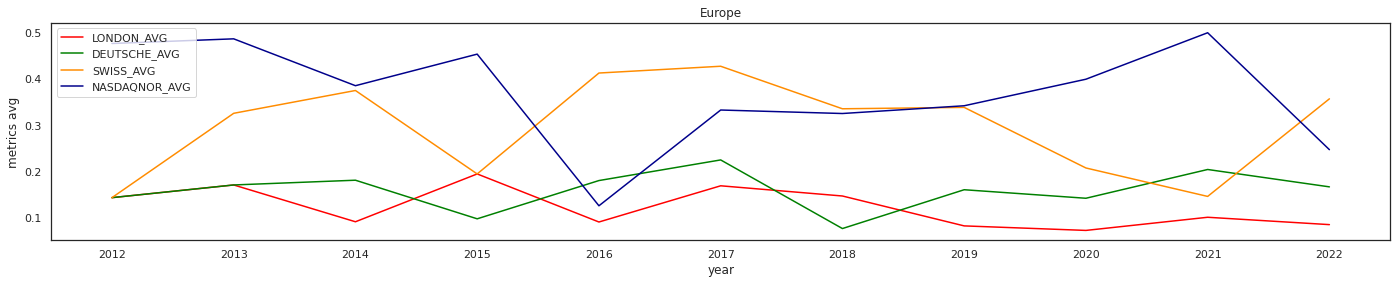

In [63]:
# and plot the graph with the overall results
plt.figure(figsize=(24, 4))

# set the theme for the plot
sns.set_theme(style="white")

plt.plot(df_metrics['london_avg'], color='red', label='LONDON_AVG')
plt.plot(df_metrics['deutsche_avg'], color='green', label='DEUTSCHE_AVG')
plt.plot(df_metrics['swiss_avg'], color='darkorange', label='SWISS_AVG')
plt.plot(df_metrics['nor_avg'], color='darkblue', label='NASDAQNOR_AVG')

plt.xlabel('year')
plt.ylabel('metrics avg')
plt.title('Europe')
plt.legend(loc="upper left")

plt.show()

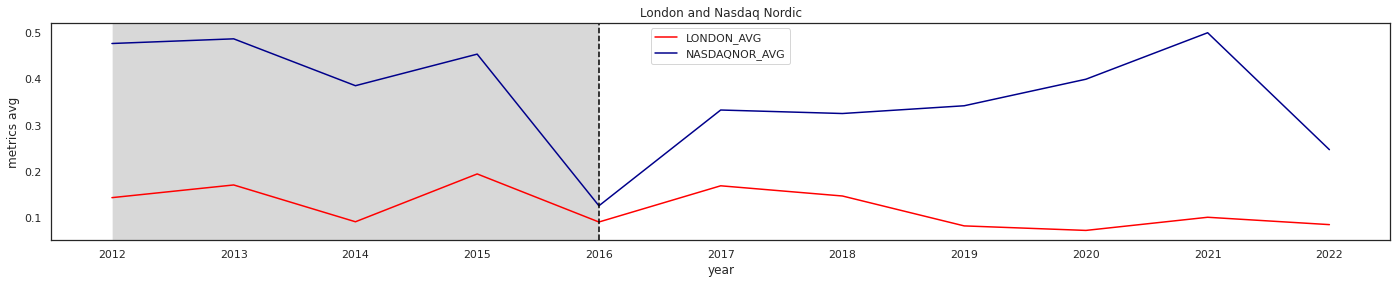

In [64]:
# highlight that in the period 2012 to 2016, London shares a pattern with Nasdaq Nordic
plt.figure(figsize=(24, 4))

# set the theme for the plot
sns.set_theme(style="white")

plt.plot(df_metrics['london_avg'], color='red', label='LONDON_AVG')
#plt.plot(df_metrics['deutsche_avg'], color='green', label='DEUTSCHE_AVG')
#plt.plot(df_metrics['swiss_avg'], color='darkorange', label='SWISS_AVG')
plt.plot(df_metrics['nor_avg'], color='darkblue', label='NASDAQNOR_AVG')

plt.axvline(x='2016', color='black', linestyle='--')
plt.axvspan('2012', '2016', facecolor='grey', alpha=0.3)

plt.xlabel('year')
plt.ylabel('metrics avg')
plt.title('London and Nasdaq Nordic')
plt.legend(loc="upper center")

plt.show()

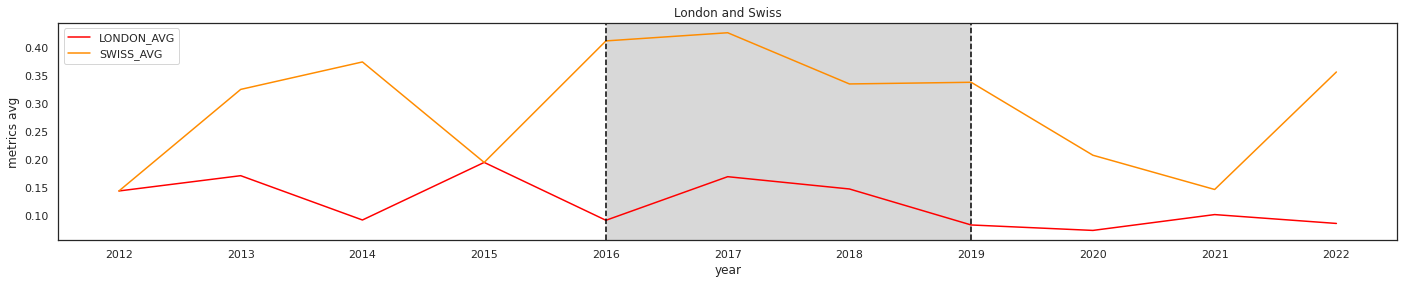

In [65]:
# highlight that in the period 2016 to 2019, London shares a pattern with the Swiss Market Index
plt.figure(figsize=(24, 4))

# set the theme for the plot
sns.set_theme(style="white")

plt.plot(df_metrics['london_avg'], color='red', label='LONDON_AVG')
#plt.plot(df_metrics['deutsche_avg'], color='green', label='DEUTSCHE_AVG')
plt.plot(df_metrics['swiss_avg'], color='darkorange', label='SWISS_AVG')
#plt.plot(df_metrics['nor_avg'], color='darkblue', label='NASDAQNOR_AVG')

plt.axvline(x='2016', color='black', linestyle='--')
plt.axvline(x='2019', color='black', linestyle='--')
plt.axvspan('2016', '2019', facecolor='grey', alpha=0.3)

plt.xlabel('year')
plt.ylabel('metrics avg')
plt.title('London and Swiss')
plt.legend(loc="upper left")

plt.show()

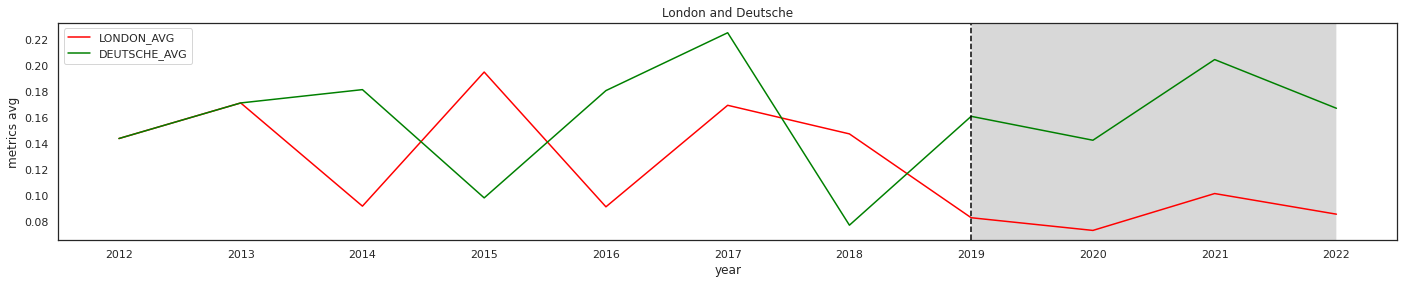

In [66]:
# highlight that after 2019, London shares a pattern with Deutsche Boerse
plt.figure(figsize=(24, 4))

# set the theme for the plot
sns.set_theme(style="white")

plt.plot(df_metrics['london_avg'], color='red', label='LONDON_AVG')
plt.plot(df_metrics['deutsche_avg'], color='green', label='DEUTSCHE_AVG')
#plt.plot(df_metrics['swiss_avg'], color='darkorange', label='SWISS_AVG')
#plt.plot(df_metrics['nor_avg'], color='darkblue', label='NASDAQNOR_AVG')

plt.axvline(x='2019', color='black', linestyle='--')
plt.axvspan('2019', '2022', facecolor='grey', alpha=0.3)

plt.xlabel('year')
plt.ylabel('metrics avg')
plt.title('London and Deutsche')
plt.legend(loc="upper left")

plt.show()

London was never influential in the past decade - and over the last four years, it has lost more of what little it had.